**EXP4 Predicitng Missing Cell-Types from Dissociated and Classic Bulks using the Residual**

Data downloaded from: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE217517

Cell types per sample from original paper: https://github.com/greenelab/deconvolution_pilot/tree/main/data/cell_labels

*This file includes EXP4 specifics (outlined below), as well as the data preprocessing, QC, and creates the pseudobulks used in other experiments.*

In [83]:
# import the dependencies
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
sys.path.insert(1, '../../../../../')

from functions import sn_sc_preprocess
from functions import validation_processing as vp
from importlib import reload
reload(sn_sc_preprocess)
reload(vp)
# general imports
import warnings
import numpy as np
from numpy import random
from numpy import array
from numpy import diag
from numpy import dot
from numpy import zeros
import pandas as pd
import scanpy as sc
from anndata import AnnData as ad
from tabulate import tabulate

import tensorflow as tf
import sklearn as sk
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import FunctionTransformer
import scipy as sp
from scipy.stats import spearmanr, pearsonr
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
from scipy.stats import wilcoxon
import scipy.stats as stats
from collections import Counter
import scipy as sp
from scipy.optimize import nnls
from scipy.stats import ttest_ind
# Images, plots, display, and visualization
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib.colors as mcolors
import seaborn as sns

import seaborn as sns
from scipy import stats
from openTSNE import TSNE
from openTSNE import TSNEEmbedding
from openTSNE import affinity
from openTSNE import initialization
#sklearns
from sklearn.decomposition import FastICA
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
#from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier

from biomart import BiomartServer
import rpy2 as rpy2
from rpy2.robjects import pandas2ri
from rpy2.robjects import r, globalenv
from rpy2.robjects.packages import importr
# programming stuff
import time
import os, sys
from io import StringIO 
import pickle
import requests
from pathlib import Path

In [84]:
#####################
### set the study ###
#####################
#results paths:
res_name = "MCT_hgsoc_EXP4"
actual_path = os.getcwd()
data_path = f"{actual_path}/../data/EXP4/"
bp_results_path = f"{actual_path}/../data/EXP4/BP_results/"
bp_path = f"{actual_path}/../data/EXP4/BayesPrism/"
random_seed = 88
nmf_cut = 'minimum_value'
num_samples = 10000
bulks_type= f"real"
types_of_bulks = ["classic_rrna", "dissociated_rrna", "dissociated_polya"]

## **Reading and QCing the data:**

Classic Bulks (Not Dissociated)

In [85]:
bulks_path = os.path.join(data_path, f"{res_name}_bulks.csv")
bulks_path = Path(bulks_path)
bulks = pd.read_csv(bulks_path)
bulks = bulks.drop(labels=["Unnamed: 0"], axis = 1)
bulks

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.5,AL627309.4,AP006222.2,AL732372.1,...,AC133551.1,AC136612.1,AC136616.1,AC136616.3,AC136616.2,AC141272.1,AC023491.2,AC007325.1,AC007325.4,AC007325.2
0,7,0,0,6,0,1,28,0,6,1,...,0,0,16,0,0,6,2,4,47,36
1,1,0,0,12,0,0,77,0,10,0,...,0,0,81,0,0,0,2,0,18,13
2,0,0,0,5,0,1,26,0,10,0,...,0,0,8,0,0,0,0,0,46,24
3,0,0,0,3,0,0,51,0,7,0,...,0,0,1,0,6,1,0,0,10,23
4,0,0,0,2,0,0,27,0,12,0,...,0,0,54,0,0,0,1,0,8,0
5,8,0,0,5,0,3,59,0,0,0,...,0,0,3,0,0,0,0,0,18,34
6,0,0,0,5,0,0,81,1,3,0,...,0,0,7,0,1,3,0,0,2,3
7,2,0,0,6,0,2,47,0,6,0,...,0,0,0,0,2,13,0,0,16,7


Dissociated Bulks:

In [86]:
dbulks_path = os.path.join(data_path, f"{res_name}_dissociated_bulks.csv")
dbulks_path = Path(dbulks_path)
diss_bulks = pd.read_csv(dbulks_path)
diss_bulks = diss_bulks.drop(labels=["Unnamed: 0"], axis=1)
diss_bulks

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.5,AL627309.4,AP006222.2,AL732372.1,...,AC133551.1,AC136612.1,AC136616.1,AC136616.3,AC136616.2,AC141272.1,AC023491.2,AC007325.1,AC007325.4,AC007325.2
0,3,0,0,2,0,0,15,0,1,0,...,0,0,19,0,1,1,3,4,39,28
1,1,0,0,5,0,0,63,1,6,0,...,0,0,27,0,0,0,0,0,8,6
2,3,2,0,1,0,0,7,0,5,0,...,0,0,17,0,0,2,0,0,57,30
3,4,0,0,2,0,0,37,0,2,0,...,0,0,2,0,0,0,0,0,10,21
4,2,0,0,4,0,0,31,0,3,0,...,0,0,6,0,0,6,0,0,6,2
5,1,0,0,1,0,0,33,0,2,0,...,0,0,6,0,0,1,0,0,20,16
6,1,0,0,1,0,0,26,0,5,0,...,0,0,19,0,2,11,0,1,15,3
7,8,0,0,1,0,1,38,0,0,0,...,0,0,4,0,0,4,0,0,10,9


Dissociated polyA:

In [87]:
disspolyA_bulks_path = os.path.join(data_path, f"{res_name}_dissociatedpolyA_bulks.csv")
disspolyA_bulks_path = Path(disspolyA_bulks_path)
disspolya_bulks = pd.read_csv(disspolyA_bulks_path)
disspolya_bulks = disspolya_bulks.drop(labels=["Unnamed: 0"], axis = 1)
disspolya_bulks

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.5,AL627309.4,AP006222.2,AL732372.1,...,AC133551.1,AC136612.1,AC136616.1,AC136616.3,AC136616.2,AC141272.1,AC023491.2,AC007325.1,AC007325.4,AC007325.2
0,17,2,0,10,0,2,66,0,15,1,...,0,1,35,0,0,9,9,7,56,78
1,2,1,0,7,0,3,134,0,8,0,...,0,4,58,0,1,2,0,0,15,11
2,0,0,0,1,0,0,14,0,10,0,...,0,0,35,0,0,6,0,0,51,27
3,5,1,0,6,0,0,159,0,16,0,...,0,0,2,0,2,6,0,0,27,32
4,4,0,0,13,0,4,92,0,5,0,...,0,0,16,0,0,1,0,0,4,6
5,7,0,0,11,0,9,114,0,12,0,...,0,0,9,0,0,1,0,0,10,17
6,0,0,0,5,0,1,69,0,12,0,...,0,1,33,0,4,30,0,0,6,3
7,2,0,0,6,0,1,93,0,9,1,...,0,0,6,0,2,16,0,0,10,12


Gene maps:

In [88]:
genes_path = os.path.join(data_path, f"gene_maps.csv")
genes_path = Path(genes_path)
genes = pd.read_csv(genes_path, index_col=0)
genes

,Name,Ens
0,MIR1302-2HG,ENSG00000243485
1,FAM138A,ENSG00000237613
2,OR4F5,ENSG00000186092
3,AL627309.1,ENSG00000238009
4,AL627309.3,ENSG00000239945
...,...,...
36596,AC141272.1,ENSG00000277836
36597,AC023491.2,ENSG00000278633
36598,AC007325.1,ENSG00000276017
36599,AC007325.4,ENSG00000278817


In [89]:
bulks.columns = genes["Name"]
diss_bulks.columns = genes["Name"]

And all single-cells:

In [90]:
#saved as anndata objects
adata_path = os.path.join(data_path, f"{res_name}_adatas_combined.h5ad")
adata_path = Path(adata_path)
adata = sc.read_h5ad(adata_path)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [91]:
#combining the dissociated and non dissociated
combo = pd.DataFrame(np.concatenate([bulks.values, diss_bulks.values]), columns = bulks.columns)

In [92]:
#matching index 
bulks.index = range(1,9)
diss_bulks.index = range(1,9)
disspolya_bulks.index = range(1,9)
combo.index = np.tile(range(1,9),2)
bulks

Name,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.5,AL627309.4,AP006222.2,AL732372.1,...,AC133551.1,AC136612.1,AC136616.1,AC136616.3,AC136616.2,AC141272.1,AC023491.2,AC007325.1,AC007325.4,AC007325.2
1,7,0,0,6,0,1,28,0,6,1,...,0,0,16,0,0,6,2,4,47,36
2,1,0,0,12,0,0,77,0,10,0,...,0,0,81,0,0,0,2,0,18,13
3,0,0,0,5,0,1,26,0,10,0,...,0,0,8,0,0,0,0,0,46,24
4,0,0,0,3,0,0,51,0,7,0,...,0,0,1,0,6,1,0,0,10,23
5,0,0,0,2,0,0,27,0,12,0,...,0,0,54,0,0,0,1,0,8,0
6,8,0,0,5,0,3,59,0,0,0,...,0,0,3,0,0,0,0,0,18,34
7,0,0,0,5,0,0,81,1,3,0,...,0,0,7,0,1,3,0,0,2,3
8,2,0,0,6,0,2,47,0,6,0,...,0,0,0,0,2,13,0,0,16,7


In [93]:
print(Counter(adata.obs["cell_types"]))
# define the number of cells and the list of missing cell counts
num_cells = len(adata.obs.cell_types.unique())
cell_order = adata.obs.cell_types.unique()

Counter({'T cells': 7419, 'Plasma cells': 1983, 'Epithelial cells': 1694, 'Fibroblasts': 1587, 'Endothelial cells': 1189, 'Macrophages': 1116, 'NK cells': 842, 'Monocytes': 272, 'B cells': 264, 'pDC': 170, 'DC': 98, 'ILC': 89})


## **Reading In and QCing the BayesPrism Results:**

In [94]:
#import all BayesPrism results (through using InstaPrism) and real proportions
bp_prop = dict()
ref_bp = dict()
gene_ids = dict()
num=0
for bulktype in types_of_bulks:
    bulktype = str(bulktype)
    res_p = os.path.join(bp_results_path, f"{res_name}_{bulks_type}_{num}missing_{bulktype}_InstaPrism_results.csv")
    res_p = Path(res_p)
    # Open the CSV file in read mode
    bp_prop[bulktype] = pd.read_csv(res_p, sep="\t")
    bp_prop[bulktype] = bp_prop[bulktype].T

    #and the reference used in BP
    ref_results_path = os.path.join(bp_results_path, f"{res_name}_{bulks_type}_{num}missing_{bulktype}_InstaPrism_usedref.csv")
    ref_results_path = Path(ref_results_path)
    # Open the CSV file in read mode
    ref_bp[bulktype] = pd.read_csv(ref_results_path, sep="\t")
    #gene ids used for each
    gene_ids[bulktype] = np.intersect1d(bulks.columns, ref_bp[bulktype].index)

Extracting makers:

In [95]:
#Reading in the CIBERSORTx barcode genes
cibersort_ref = dict()
cibersort_genes = dict()
cibersort_results_path = f"{actual_path}/../data/EXP4/cibersort_results/"
print("genes to keep per experiment:")
for num in range(1,9):    
    # read in cibersort genes / cibersort reference
    cibersort_path_ = os.path.join(cibersort_results_path, f"CIBERSORTx_{res_name}_{bulks_type}_{num}missing_signal_inferred_phenoclasses.CIBERSORTx_{res_name}_{bulks_type}_{num}missing_signal_inferred_refsample.bm.K999.txt")
    cibersort_path_ = Path(cibersort_path_)
    cibersort_df = pd.read_csv(cibersort_path_, sep="\t")
    cibersort_genes[num] = pd.DataFrame(columns = cibersort_df["NAME"].values.tolist())
    cibersort_df.index = cibersort_genes[num].columns
    cibersort_ref[num] = cibersort_df.drop(columns = "NAME", inplace=False)
cibersort_genes = cibersort_genes[1].columns
cibersort_genes = cibersort_genes.tolist()
cibersort_genes

genes to keep per experiment:


['A1BG',
 'A2M',
 'AAGAB',
 'AASS',
 'AATK',
 'ABCA1',
 'ABCA10',
 'ABCA5',
 'ABCA6',
 'ABCA9',
 'ABCB1',
 'ABCC4',
 'ABCC9',
 'ABCE1',
 'ABHD12',
 'ABHD15',
 'ABHD15.AS1',
 'ABHD17A',
 'ABHD17C',
 'ABHD2',
 'ABHD3',
 'ABI2',
 'ABI3BP',
 'ABL2',
 'ABLIM1',
 'ABR',
 'ABRACL',
 'ABTB2',
 'AC002091.1',
 'AC002429.2',
 'AC004687.1',
 'AC004817.3',
 'AC004854.2',
 'AC005037.1',
 'AC005261.1',
 'AC005264.1',
 'AC005480.1',
 'AC005920.2',
 'AC006064.2',
 'AC006449.6',
 'AC007032.1',
 'AC007365.1',
 'AC007381.1',
 'AC007384.1',
 'AC007569.1',
 'AC007991.3',
 'AC008014.1',
 'AC008105.3',
 'AC008569.1',
 'AC008691.1',
 'AC008696.2',
 'AC008760.2',
 'AC008764.7',
 'AC008764.8',
 'AC009313.1',
 'AC010609.1',
 'AC010883.3',
 'AC010894.3',
 'AC011462.5',
 'AC011476.3',
 'AC011511.2',
 'AC012184.4',
 'AC012368.1',
 'AC012447.1',
 'AC013652.1',
 'AC015871.7',
 'AC015912.3',
 'AC016831.1',
 'AC017101.1',
 'AC017104.1',
 'AC018682.1',
 'AC018755.4',
 'AC018816.1',
 'AC020656.1',
 'AC021180.1',
 'AC02159

In [96]:
#From deconv paper:
#Erythocyte markers
eryth_markers = ['ALAS2','HBB', 'HBA2','HBA1']
#Dissociation Response
diss_response = ['PYDC1', 'PRRR35', 'AGXT', 'EREG', 'CSF3', 'ASTL'
    'HSPC3', 'SELE', 'IL1B', 'TRIM72', 'CTRB2', 'RNF223', 'CSF2','CXCL8',
    'KRT17', 'PMAIP1', 'CSF2','ADRA2B','CCL3L1', 'SLC32A1','DLX2','CXCR1','LEP',
    'TEX48','FCGR3B','CXCR2','THRSP','TMC2', 'AL845331.2','SLC7A10','BOD1L2',
    'SERPINI2','BLID']
#And adipocyte markers
adipocyte_genes = ["PLIN1", "CIDEC", "GPD1", "ACVR1C"]

#adipocyte markers from CellMarker
markers_path = os.path.join(data_path, f"CellMarker.csv")
markers_path = Path(markers_path)
markers = pd.read_csv(markers_path)
adip_markers = markers["Cell Marker"]
adip_markers = adip_markers.tolist()
adip_markers.append(adipocyte_genes)
#deleting genes that are also highly expressed in cancer
removed_marker = ['CD44','CD45','CD34','CD29','CD137','CD106']
for remove_gene in removed_marker:
    adip_markers.remove(remove_gene)
adip_markers

['ACRP30',
 'ADIPOR1',
 'ADIPOR2',
 'BSCL2',
 'CHC22',
 'CIDEA',
 'DLK1',
 'DLK2',
 'FABP4',
 'FATP1',
 'FATP2',
 'FATP4',
 'FATP5',
 'FATP6',
 'GLUT4',
 'Galectin-12',
 'HLA-ABC',
 'Leptin',
 'PGC-1-alpha',
 'PPARgamma',
 'Perilipin-2',
 'UCP1',
 'VSTM2A',
 'VSTM2B',
 'ZIC1',
 'gACRP30',
 ['PLIN1', 'CIDEC', 'GPD1', 'ACVR1C']]

In [97]:
#Some of the names are not in the right format, so reassigning manually
adip_markers = np.array(adip_markers)
adip_markers = ['ACRP30', 'ADIPOR1', 'ADIPOR2', 'CIDEA', 'FABP4',
       'FATP1', 'FATP2', 'FATP4', 'FATP5', 'FATP6', 'GLUT4',
       'LGALS12', 'LEP', 'PPARG',
       'PLIN1', 'UCP1', 'GACRP30','ACVR1C', 
       'CIDEC', 'GPD1', 'ADIPOQ', 'MRAP', 'TRARG1', 'ADGRL4', 'LIPE']

/var/folders/d3/x10lxf7x1n37__s3n36qxmlw0000gp/T/ipykernel_13620/1432233138.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  adip_markers = np.array(adip_markers)


In [98]:
cibersort_genes = bulks.columns
cibersort_genes

Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3',
       'AL627309.2', 'AL627309.5', 'AL627309.4', 'AP006222.2', 'AL732372.1',
       ...
       'AC133551.1', 'AC136612.1', 'AC136616.1', 'AC136616.3', 'AC136616.2',
       'AC141272.1', 'AC023491.2', 'AC007325.1', 'AC007325.4', 'AC007325.2'],
      dtype='object', name='Name', length=36601)

In [99]:
#merging the cibersort, adipocyte, erythocyte, and dissociation genes:
gene_ids = list()
gene_ids.extend(cibersort_genes)
gene_ids.extend(adip_markers)
gene_ids.extend(eryth_markers)
gene_ids.extend(diss_response)
gene_ids

['MIR1302-2HG',
 'FAM138A',
 'OR4F5',
 'AL627309.1',
 'AL627309.3',
 'AL627309.2',
 'AL627309.5',
 'AL627309.4',
 'AP006222.2',
 'AL732372.1',
 'OR4F29',
 'AC114498.1',
 'OR4F16',
 'AL669831.2',
 'LINC01409',
 'FAM87B',
 'LINC01128',
 'LINC00115',
 'FAM41C',
 'AL645608.6',
 'AL645608.2',
 'AL645608.4',
 'LINC02593',
 'SAMD11',
 'NOC2L',
 'KLHL17',
 'PLEKHN1',
 'PERM1',
 'AL645608.7',
 'HES4',
 'ISG15',
 'AL645608.1',
 'AGRN',
 'AL645608.5',
 'AL645608.8',
 'RNF223',
 'C1orf159',
 'AL390719.3',
 'LINC01342',
 'AL390719.2',
 'TTLL10-AS1',
 'TTLL10',
 'TNFRSF18',
 'TNFRSF4',
 'SDF4',
 'B3GALT6',
 'C1QTNF12',
 'AL162741.1',
 'UBE2J2',
 'LINC01786',
 'SCNN1D',
 'ACAP3',
 'PUSL1',
 'INTS11',
 'AL139287.1',
 'CPTP',
 'TAS1R3',
 'DVL1',
 'MXRA8',
 'AURKAIP1',
 'CCNL2',
 'MRPL20-AS1',
 'MRPL20',
 'AL391244.2',
 'ANKRD65',
 'AL391244.1',
 'TMEM88B',
 'LINC01770',
 'VWA1',
 'ATAD3C',
 'ATAD3B',
 'ATAD3A',
 'TMEM240',
 'SSU72',
 'AL645728.1',
 'FNDC10',
 'AL691432.4',
 'AL691432.2',
 'MIB2',
 'MMP

In [100]:
gene_ids = np.intersect1d(gene_ids, ref_bp["classic_rrna"].index)
gene_ids = np.intersect1d(gene_ids, ref_bp["dissociated_rrna"].index)
gene_ids = np.intersect1d(gene_ids, ref_bp["dissociated_polya"].index)
print(len(gene_ids))

13706


In [101]:
gene_ids = np.intersect1d(gene_ids, bulks.columns)

bulks = bulks[gene_ids]
diss_bulks= diss_bulks[gene_ids]
disspolya_bulks = disspolya_bulks[gene_ids]
combo = combo[gene_ids]
combo

Name,A1BG,A1BG-AS1,A2M,A2M-AS1,A4GALT,AAAS,AACS,AAGAB,AAK1,AAMDC,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
1,135,98,24716,183,256,2006,1193,917,4091,103,...,439,412,635,1562,221,388,1786,2614,4515,3405
2,107,101,6238,59,220,1214,1144,703,3001,549,...,161,993,296,593,203,304,2435,1305,2166,2644
3,82,85,4221,60,351,823,535,454,1978,100,...,123,439,223,713,271,361,1820,703,563,3075
4,29,35,39378,82,983,736,2297,962,2053,125,...,325,599,169,52,229,559,944,2068,3452,3626
5,51,47,11374,71,62,1027,567,989,1880,134,...,334,346,452,582,188,253,1583,1349,2199,2842
6,300,196,12922,91,618,1365,1235,1281,3525,223,...,370,1441,446,1358,214,251,2067,2039,1344,3102
7,27,28,53177,134,410,852,691,861,2336,68,...,309,511,191,285,218,306,878,1367,3601,3762
8,81,87,31569,150,365,1185,633,727,4366,134,...,283,589,260,116,358,391,1801,2234,3344,5021
1,197,55,32868,96,420,1492,814,838,2921,83,...,403,376,439,899,197,449,1653,2287,5759,2886
2,81,59,26055,64,257,729,541,437,2236,190,...,212,487,153,502,135,145,1176,1078,2800,2628


In [102]:
# #cutting all to only include marker genes and barcode genes from bayesprism.
# bulks = bulks[gene_ids["classic_rrna"]]
# diss_bulks= diss_bulks[gene_ids["dissociated_rrna"]]
# disspolya_bulks = disspolya_bulks[gene_ids["dissociated_polya"]]
# combo = combo[np.intersect1d(gene_ids["dissociated_rrna"], gene_ids["classic_rrna"])]
# combo

Normalizing bulk counts:

In [103]:
combo_norm = pd.DataFrame(columns=bulks.columns)
for idx, bulk in combo.iterrows():
    pseudo_df = pd.DataFrame(bulk)
    clip_upper = np.quantile(pseudo_df, 0.90)
    pseudo_df = np.clip(pseudo_df, 0, clip_upper)
    #and normalize to values between 0 and 1
    scaler = MinMaxScaler()
    scaler.fit(pseudo_df)
    normalized_pseudo_df = scaler.transform(pseudo_df)
    combo_norm = combo_norm.append(pd.DataFrame(normalized_pseudo_df.T, columns = combo_norm.columns))
combo = combo_norm.copy()
idx = np.tile(range(1,9), 2)
combo.index = idx
combo

Name,A1BG,A1BG-AS1,A2M,A2M-AS1,A4GALT,AAAS,AACS,AAGAB,AAK1,AAMDC,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
1,0.034780,0.025248,1.0,0.047147,0.065954,0.516811,0.307355,0.236249,1.000000,0.026536,...,0.113101,0.106145,0.163597,0.402422,0.056937,0.099961,0.460131,0.673451,1.000000,0.877238
2,0.036644,0.034589,1.0,0.020205,0.075342,0.415753,0.391781,0.240753,1.000000,0.188014,...,0.055137,0.340068,0.101370,0.203082,0.069521,0.104110,0.833904,0.446918,0.741781,0.905479
3,0.039709,0.041162,1.0,0.029056,0.169976,0.398547,0.259080,0.219855,0.957869,0.048426,...,0.059564,0.212591,0.107990,0.345278,0.131235,0.174818,0.881356,0.340436,0.272639,1.000000
4,0.008007,0.009663,1.0,0.022639,0.271397,0.203203,0.634180,0.265599,0.566814,0.034511,...,0.089729,0.165378,0.046659,0.014357,0.063225,0.154335,0.260629,0.570955,0.953065,1.000000
5,0.018991,0.017501,1.0,0.026438,0.023087,0.382424,0.211134,0.368274,0.700056,0.049898,...,0.124372,0.128840,0.168311,0.216719,0.070006,0.094210,0.589462,0.502327,0.818842,1.000000
6,0.080332,0.052484,1.0,0.024367,0.165484,0.365511,0.330700,0.343018,0.943901,0.059713,...,0.099076,0.385862,0.119427,0.363636,0.057304,0.067211,0.553488,0.545990,0.359888,0.830633
7,0.009199,0.009540,1.0,0.045656,0.139693,0.290290,0.235434,0.293356,0.795911,0.023169,...,0.105281,0.174106,0.065077,0.097104,0.074276,0.104259,0.299148,0.465758,1.000000,1.000000
8,0.024204,0.025997,1.0,0.044823,0.109069,0.354101,0.189153,0.217242,1.000000,0.040042,...,0.084566,0.176005,0.077693,0.034663,0.106977,0.116838,0.538174,0.667563,0.999253,1.000000
1,0.048968,0.013671,1.0,0.023863,0.104400,0.370868,0.202337,0.208302,0.726075,0.020631,...,0.100174,0.093463,0.109123,0.223465,0.048968,0.111608,0.410887,0.568481,1.000000,0.717375
2,0.035187,0.025630,1.0,0.027802,0.111642,0.316681,0.235013,0.189835,0.971329,0.082537,...,0.092094,0.211555,0.066464,0.218071,0.058645,0.062989,0.510860,0.468288,1.000000,1.000000


In [104]:
bulks_norm = pd.DataFrame(columns=bulks.columns)
for idx, bulk in bulks.iterrows():
    pseudo_df = pd.DataFrame(bulk)
    clip_upper = np.quantile(pseudo_df, 0.90)
    pseudo_df = np.clip(pseudo_df, 0, clip_upper)
    #and normalize to values between 0 and 1
    scaler = MinMaxScaler()
    scaler.fit(pseudo_df)
    normalized_pseudo_df = scaler.transform(pseudo_df)
    bulks_norm = bulks_norm.append(pd.DataFrame(normalized_pseudo_df.T, columns = bulks_norm.columns))
bulks = bulks_norm.copy()
bulks.index = range(1, len(bulks)+1)
bulks

Name,A1BG,A1BG-AS1,A2M,A2M-AS1,A4GALT,AAAS,AACS,AAGAB,AAK1,AAMDC,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
1,0.034780,0.025248,1.0,0.047147,0.065954,0.516811,0.307355,0.236249,1.000000,0.026536,...,0.113101,0.106145,0.163597,0.402422,0.056937,0.099961,0.460131,0.673451,1.000000,0.877238
2,0.036644,0.034589,1.0,0.020205,0.075342,0.415753,0.391781,0.240753,1.000000,0.188014,...,0.055137,0.340068,0.101370,0.203082,0.069521,0.104110,0.833904,0.446918,0.741781,0.905479
3,0.039709,0.041162,1.0,0.029056,0.169976,0.398547,0.259080,0.219855,0.957869,0.048426,...,0.059564,0.212591,0.107990,0.345278,0.131235,0.174818,0.881356,0.340436,0.272639,1.000000
4,0.008007,0.009663,1.0,0.022639,0.271397,0.203203,0.634180,0.265599,0.566814,0.034511,...,0.089729,0.165378,0.046659,0.014357,0.063225,0.154335,0.260629,0.570955,0.953065,1.000000
5,0.018991,0.017501,1.0,0.026438,0.023087,0.382424,0.211134,0.368274,0.700056,0.049898,...,0.124372,0.128840,0.168311,0.216719,0.070006,0.094210,0.589462,0.502327,0.818842,1.000000
6,0.080332,0.052484,1.0,0.024367,0.165484,0.365511,0.330700,0.343018,0.943901,0.059713,...,0.099076,0.385862,0.119427,0.363636,0.057304,0.067211,0.553488,0.545990,0.359888,0.830633
7,0.009199,0.009540,1.0,0.045656,0.139693,0.290290,0.235434,0.293356,0.795911,0.023169,...,0.105281,0.174106,0.065077,0.097104,0.074276,0.104259,0.299148,0.465758,1.000000,1.000000
8,0.024204,0.025997,1.0,0.044823,0.109069,0.354101,0.189153,0.217242,1.000000,0.040042,...,0.084566,0.176005,0.077693,0.034663,0.106977,0.116838,0.538174,0.667563,0.999253,1.000000


In [105]:
diss_bulks_norm = pd.DataFrame(columns=diss_bulks.columns)
for idx, bulk in diss_bulks.iterrows():
    pseudo_df = pd.DataFrame(bulk)
    clip_upper = np.quantile(pseudo_df, 0.90)
    pseudo_df = np.clip(pseudo_df, 0, clip_upper)
    #and normalize to values between 0 and 1
    scaler = MinMaxScaler()
    scaler.fit(pseudo_df)
    normalized_pseudo_df = scaler.transform(pseudo_df)
    diss_bulks_norm = diss_bulks_norm.append(pd.DataFrame(normalized_pseudo_df.T, columns = diss_bulks_norm.columns))
diss_bulks = diss_bulks_norm.copy()
diss_bulks.index = range(1, len(diss_bulks)+1)
diss_bulks

Name,A1BG,A1BG-AS1,A2M,A2M-AS1,A4GALT,AAAS,AACS,AAGAB,AAK1,AAMDC,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
1,0.048968,0.013671,1.0,0.023863,0.104400,0.370868,0.202337,0.208302,0.726075,0.020631,...,0.100174,0.093463,0.109123,0.223465,0.048968,0.111608,0.410887,0.568481,1.000000,0.717375
2,0.035187,0.025630,1.0,0.027802,0.111642,0.316681,0.235013,0.189835,0.971329,0.082537,...,0.092094,0.211555,0.066464,0.218071,0.058645,0.062989,0.510860,0.468288,1.000000,1.000000
3,0.077259,0.019522,1.0,0.009969,0.150779,0.235099,0.310696,0.218069,0.369263,0.021599,...,0.053998,0.097612,0.048183,0.166563,0.117965,0.265421,0.844029,0.228037,0.680374,0.890966
4,0.026295,0.012827,1.0,0.017957,0.370050,0.173802,0.280904,0.229918,0.486772,0.032067,...,0.064133,0.089145,0.045855,0.047779,0.110309,0.250762,0.394420,0.358506,1.000000,0.948533
5,0.014025,0.005551,1.0,0.037400,0.094960,0.340102,0.199270,0.311176,0.561286,0.022790,...,0.107232,0.159825,0.116874,0.259459,0.097882,0.164207,0.399708,0.495252,1.000000,0.871877
6,0.049303,0.024327,1.0,0.021732,0.163477,0.367175,0.296464,0.239053,0.580279,0.039247,...,0.080765,0.266299,0.086604,0.236458,0.065521,0.131041,0.641259,0.525787,0.782030,0.676938
7,0.026550,0.018077,1.0,0.045756,0.097161,0.231041,0.113826,0.224262,0.608671,0.023161,...,0.091795,0.086428,0.091230,0.142070,0.058749,0.115520,0.326225,0.361813,1.000000,0.978110
8,0.020411,0.007654,1.0,0.024239,0.245256,0.166162,0.136182,0.197098,0.689204,0.028704,...,0.082602,0.103014,0.055494,0.033169,0.131399,0.226120,0.505820,0.438845,0.994738,0.993143


In [106]:
disspolya_bulks_norm = pd.DataFrame(columns= disspolya_bulks.columns)
for idx, bulk in disspolya_bulks.iterrows():
    pseudo_df = pd.DataFrame(bulk)
    clip_upper = np.quantile(pseudo_df, 0.90)
    pseudo_df = np.clip(pseudo_df, 0, clip_upper)
    #and normalize to values between 0 and 1
    scaler = MinMaxScaler()
    scaler.fit(pseudo_df)
    normalized_pseudo_df = scaler.transform(pseudo_df)
    disspolya_bulks_norm = disspolya_bulks_norm.append(pd.DataFrame(normalized_pseudo_df.T, columns = disspolya_bulks_norm.columns))
disspolya_bulks = disspolya_bulks_norm.copy()
disspolya_bulks.index = range(1, len(diss_bulks)+1)
disspolya_bulks

,A1BG,A1BG-AS1,A2M,A2M-AS1,A4GALT,AAAS,AACS,AAGAB,AAK1,AAMDC,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
1,0.026358,0.014005,1.0,0.011309,0.081858,0.444522,0.216346,0.194859,0.993780,0.020095,...,0.084207,0.054630,0.108738,0.242878,0.020791,0.106389,0.354574,0.323431,1.0,0.862424
2,0.033426,0.020055,1.0,0.020516,0.118488,0.500231,0.189719,0.198248,0.827109,0.063163,...,0.100507,0.147303,0.079299,0.271093,0.025818,0.046796,0.436376,0.323190,1.0,0.929000
3,0.032566,0.009267,1.0,0.007678,0.109876,0.319301,0.253111,0.225576,0.337305,0.022240,...,0.037331,0.070426,0.042891,0.162298,0.052158,0.314271,0.800371,0.142706,1.0,0.920572
4,0.012538,0.009366,1.0,0.009366,0.241541,0.242145,0.250000,0.242749,0.637613,0.037311,...,0.069335,0.058157,0.057704,0.053323,0.046828,0.298187,0.303172,0.230514,1.0,1.000000
5,0.007438,0.005386,1.0,0.015132,0.100026,0.480123,0.195178,0.317261,0.841498,0.017953,...,0.085150,0.112080,0.091305,0.288023,0.030521,0.187740,0.321364,0.304694,1.0,1.000000
6,0.018523,0.011958,1.0,0.013599,0.132474,0.487925,0.275498,0.236108,0.722626,0.033998,...,0.077843,0.177726,0.108792,0.237749,0.021805,0.125909,0.532943,0.359203,1.0,0.761313
7,0.015267,0.016595,1.0,0.008187,0.081204,0.325036,0.135856,0.247372,0.821330,0.026994,...,0.091603,0.057307,0.078770,0.144928,0.028322,0.141830,0.277464,0.207988,1.0,1.000000
8,0.010877,0.004944,1.0,0.013250,0.176407,0.237318,0.144171,0.169089,0.850391,0.028676,...,0.067042,0.071393,0.056759,0.026501,0.063087,0.254919,0.421833,0.283793,1.0,1.000000


In [107]:
bp_ref_norm= dict()
for bulktype in types_of_bulks:
    ref_raw_all = ref_bp[bulktype]
    ref_raw_all = ref_raw_all.loc[gene_ids]
    #gene_ids = ref_raw_all.index
    #clippign before scaling to 95th pecentile
    ref_raw_val = ref_raw_all.values
    clip_upper = np.quantile(ref_raw_val, 0.95)
    ref_raw_val = np.clip(ref_raw_val, 0, clip_upper)
    #and scaling to be between values 0 and 1 to use for NNLS
    scaler = MinMaxScaler()
    scaler.fit(ref_raw_val)
    ref_df = scaler.transform(ref_raw_val)
    ref_df = pd.DataFrame(ref_df, index = gene_ids, columns = ref_raw_all.columns)
    ref_raw = pd.DataFrame(ref_raw_val, index = gene_ids, columns = ref_raw_all.columns)
    bp_ref_norm[bulktype] = ref_df

In [108]:
# bp_ref_norm= dict()
# for bulktype in types_of_bulks:
#     ref_raw_all = ref_bp[bulktype]
#     gene_ids = ref_raw_all.index
#     #clippign before scaling to 95th pecentile
#     ref_raw_val = ref_raw_all.values
#     clip_upper = np.quantile(ref_raw_val, 0.95)
#     ref_raw_val = np.clip(ref_raw_val, 0, clip_upper)
#     #and scaling to be between values 0 and 1 to use for NNLS
#     scaler = MinMaxScaler()
#     scaler.fit(ref_raw_val)
#     ref_df = scaler.transform(ref_raw_val)
#     ref_df = pd.DataFrame(ref_df, index = gene_ids, columns = ref_raw_all.columns)
#     ref_raw = pd.DataFrame(ref_raw_val, index = gene_ids, columns = ref_raw_all.columns)
#     bp_ref_norm[bulktype] = ref_df

## Evalutating BayesPrism Performance:

In [109]:
# # Sample data for "Classic Bulks" and "Dissociated Bulks"
# classic_bulks_values = calc_res_tot_bulks.values[0]
# dissociated_bulks_values = calc_res_tot_dissbulks.values[0]
# dissociatedpolya_bulks_values = calc_res_tot_disspolyabulks.values[0]

# # Create x-coordinates for the bars
# x_coordinates = np.arange(len(classic_bulks_values))
# # Width of each bar
# bar_width = 0.25

# plt.figure(figsize=(15, 6))

# # Plot "Classic Bulks" residuals
# plt.bar(x_coordinates, classic_bulks_values, width=bar_width, alpha=0.7, label='Classic Bulks')

# # Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
# plt.bar(x_coordinates + bar_width, dissociated_bulks_values, width=bar_width, alpha=0.7, label='Dissociated Bulks')

# # Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
# plt.bar(x_coordinates + bar_width + bar_width, dissociatedpolya_bulks_values, width=bar_width, alpha=0.7, label='Dissociated polyA Bulks')

# plt.xlabel('Sample ID')
# plt.ylabel('Residuals (sum of squared difference)')
# plt.title('Residuals for Classic Bulks and Dissociated Bulks')
# plt.xticks(x_coordinates + bar_width, x_coordinates + 1)  # Adjust x-axis labels

# # Move the legend to the upper right corner
# plt.legend(loc='lower right')

# plt.show()

In [110]:
# # Sample data for "Classic Bulks" and "Dissociated Bulks"
# classic_bulks_values = calc_res_tot_bulks.values[0]
# dissociated_bulks_values = calc_res_tot_dissbulks.values[0]

# # Create x-coordinates for the bars
# x_coordinates = np.arange(len(classic_bulks_values))
# # Width of each bar
# bar_width = 0.4

# plt.figure(figsize=(15, 6))

# # Plot "Classic Bulks" residuals
# plt.bar(x_coordinates, classic_bulks_values, width=bar_width, alpha=0.7, label='Classic Bulks')

# # Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
# plt.bar(x_coordinates + bar_width, dissociated_bulks_values, width=bar_width, alpha=0.7, label='Dissociated Bulks')

# plt.xlabel('Sample ID')
# plt.ylabel('Residuals (sum of squared difference)')
# plt.title('Residuals for Classic Bulks and Dissociated Bulks')
# plt.xticks(x_coordinates + bar_width, x_coordinates + 1)  # Adjust x-axis labels

# # Move the legend to the upper right corner
# plt.legend(loc='lower right')

# plt.show()

In [111]:
# # Sample data for "Classic Bulks" and "Dissociated Bulks"
# classic_bulks_values = calc_res_tot_bulks.values[0]
# dissociated_bulks_values = calc_res_tot_dissbulks.values[0]

# # Combine data into a DataFrame
# df = pd.DataFrame({'Sample Type': ['Classic Bulks'] * len(classic_bulks_values) +
#                                   ['Dissociated Bulks'] * len(dissociated_bulks_values),
#                    'Residuals': np.concatenate([classic_bulks_values, dissociated_bulks_values])})

# # Create a figure and axis for violin plots
# plt.figure(figsize=(9, 6))
# ax = plt.gca()

# # Create violin plots for the two datasets
# sns.violinplot(x='Sample Type', y='Residuals', data=df, ax=ax, inner='quartile', palette=['lightblue', 'lightgreen'])

# # Add labels to the x-axis
# ax.set_xticklabels(['Classic (-rRNA) Bulks', 'Dissociated (-rRNA) Bulks'], fontsize=16, fontname='Arial',fontweight='bold')

# # Calculate p-value for the Wilcoxon signed-rank test
# t_statistic, p_value = wilcoxon(classic_bulks_values, dissociated_bulks_values)

# # Set a significance level (e.g., 0.05)
# alpha = 0.05

# # Determine if the difference is statistically significant
# if p_value < alpha:
#     significance_label = f"Significant p={np.round(p_value, 3)}"
#     asterisks = vp.convert_pvalue_to_asterisks(p_value)
#     x1, x2 = 0, 1
#     y1, y2 = 22.5, max(df['Residuals']) + 2.4
#     # Add a line and asterisks to indicate statistical significance
#     plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
#     plt.text((x1 + x2) / 2, y2-.25, asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
# else:
#     significance_label = f"Not Significant p={np.round(p_value, 3)}"
#     # No asterisks for non-significant results

# # Add the significance label and the name of the statistical test to the plot
# #plt.text(.5, max(df['Residuals']), f'Wilcoxon T-Test: {significance_label}', fontsize=12, fontweight='bold', fontname='Arial')

# plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
# plt.ylabel('Residuals (sum of squared difference)', fontsize=16, fontname='Arial')
# plt.title('Deconv. Unexplained Variance: Classic Bulks and Dissociated Bulks', fontsize=16, fontname='Arial', fontweight='bold', x=0.5, y=1.03)
# plt.ylim(14.5, 24)
# plt.show()

In [112]:
# # Sample data for "Classic Bulks" and "Dissociated Bulks"
# classic_bulks_values = calc_res_tot_disspolyabulks.values[0]
# dissociated_bulks_values = calc_res_tot_dissbulks.values[0]

# # Combine data into a DataFrame
# df = pd.DataFrame({'Sample Type': ['Classic Bulks'] * len(classic_bulks_values) +
#                                   ['Dissociated Bulks'] * len(dissociated_bulks_values),
#                    'Residuals': np.concatenate([classic_bulks_values, dissociated_bulks_values])})

# # Create a figure and axis for violin plots
# plt.figure(figsize=(9, 6))
# ax = plt.gca()

# # Create violin plots for the two datasets
# sns.violinplot(x='Sample Type', y='Residuals', data=df, ax=ax, inner='quartile', palette=['lightpink', 'lightgreen'])

# # Add labels to the x-axis
# ax.set_xticklabels(['Dissociated (polyA) Bulks', 'Dissociated (-rRNA) Bulks'], fontsize=16, fontname='Arial',fontweight='bold')

# # Calculate p-value for the Wilcoxon signed-rank test
# # Perform the paired t-test
# t_statistic, p_value = wilcoxon(classic_bulks_values, dissociated_bulks_values)

# # Set a significance level (e.g., 0.05)
# alpha = 0.05

# # Determine if the difference is statistically significant
# if p_value < alpha:
#     significance_label = f"Significant p={np.round(p_value, 3)}"
#     asterisks = vp.convert_pvalue_to_asterisks(p_value)
#     x1, x2 = 0, 1
#     y1, y2 = 10, max(df['Residuals']) + 2.8
#     # Add a line and asterisks to indicate statistical significance
#     plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
#     plt.text((x1 + x2) / 2, y2, asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
# else:
#     significance_label = f"Not Significant p={np.round(p_value, 3)}"
#     significance_label = f"Significant p={np.round(p_value, 3)}"
#     asterisks = vp.convert_pvalue_to_asterisks(p_value)
#     x1, x2 = 0, 1
#     y1, y2 = 19.85, max(df['Residuals']) + 2
#     # Add a line and asterisks to indicate statistical significance
#     plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
#     plt.text((x1 + x2) / 2, y2+0.03, s='N.S.', ha='center', va='bottom', fontsize=12, fontname='Arial')
#     # No asterisks for non-significant results

# # Add the significance label and the name of the statistical test to the plot
# #plt.text(.5, max(df['Residuals']), f'Wilcoxon T-Test: {significance_label}', fontsize=12, fontweight='bold', fontname='Arial')

# plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
# plt.ylabel('Residuals (sum of squared difference)', fontsize=16, fontname='Arial')
# plt.title('Deconv. Unexplained Variance: Dissociated (polyA and -rRNA) Bulks', fontsize=16, fontname='Arial', fontweight='bold', x=0.5, y=1.03)
# plt.ylim(14.5, 24)
# plt.show()

## Residuals Prep

Putting bulks together for multiplication:

Recreate Matrices:

In [113]:
#recreate matrix with calculated proportion BP and multiplying by the used reference
bulks_recreated_mat_all = pd.DataFrame(bp_ref_norm["classic_rrna"] @ bp_prop["classic_rrna"].T)
bulks_recreated_mat_all = bulks_recreated_mat_all.T
bulks_recreated_mat_all.index = range(1,9)
bulks_recreated_mat_all   

,A1BG,A1BG-AS1,A2M,A2M-AS1,A4GALT,AAAS,AACS,AAGAB,AAK1,AAMDC,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
1,0.228131,0.018656,0.444983,0.007834,0.066731,0.055681,0.049723,0.101387,0.581022,0.402167,...,0.035214,0.031894,0.057049,0.100569,0.008341,0.021792,0.109710,0.124411,0.457279,0.133380
2,0.227195,0.018537,0.448847,0.007914,0.068676,0.055750,0.049659,0.100386,0.576471,0.406720,...,0.034937,0.032046,0.057511,0.101418,0.008506,0.021633,0.109588,0.125102,0.455390,0.131816
3,0.227113,0.018531,0.460180,0.009219,0.070469,0.055151,0.049455,0.099804,0.583481,0.395546,...,0.035741,0.031603,0.056553,0.098032,0.009368,0.022169,0.108170,0.124036,0.453185,0.134400
4,0.232062,0.019120,0.480938,0.007342,0.071568,0.055836,0.051494,0.100194,0.587238,0.388258,...,0.036947,0.031726,0.055708,0.096221,0.008427,0.021659,0.107539,0.124587,0.460117,0.133656
5,0.227672,0.018745,0.460894,0.007969,0.069613,0.054830,0.049665,0.101381,0.586034,0.389337,...,0.036313,0.031773,0.055912,0.096842,0.008748,0.021265,0.108881,0.122596,0.460733,0.136425
6,0.227633,0.018787,0.457097,0.007695,0.070228,0.055204,0.049908,0.100701,0.582736,0.396861,...,0.035855,0.031945,0.056393,0.098520,0.008622,0.021884,0.109220,0.123207,0.457654,0.133666
7,0.229922,0.018997,0.462632,0.007763,0.069837,0.055464,0.050558,0.100696,0.587421,0.392027,...,0.036353,0.031723,0.055898,0.097307,0.008591,0.022317,0.108538,0.123388,0.457404,0.134008
8,0.232560,0.019000,0.451992,0.006917,0.067321,0.056472,0.051106,0.100273,0.584071,0.401553,...,0.035754,0.031955,0.057013,0.101050,0.007794,0.021342,0.109482,0.125373,0.458287,0.131800


In [114]:
#recreate matrix with calculated proportion BP and multiplying by the used reference
dissbulks_recreated_mat_all = pd.DataFrame(bp_ref_norm["dissociated_rrna"] @ bp_prop["dissociated_rrna"].T)
dissbulks_recreated_mat_all = dissbulks_recreated_mat_all.T
dissbulks_recreated_mat_all.index =  range(1,9)
dissbulks_recreated_mat_all 

,A1BG,A1BG-AS1,A2M,A2M-AS1,A4GALT,AAAS,AACS,AAGAB,AAK1,AAMDC,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
1,0.229775,0.018829,0.456818,0.007421,0.068609,0.055989,0.050534,0.100654,0.581182,0.400949,...,0.035617,0.031940,0.056885,0.099997,0.008228,0.021761,0.109109,0.125020,0.457635,0.132198
2,0.232034,0.018800,0.442324,0.007950,0.063652,0.056856,0.050700,0.101259,0.582710,0.405731,...,0.035006,0.031650,0.057457,0.102067,0.007976,0.022389,0.109202,0.126791,0.454720,0.131620
3,0.230133,0.018845,0.459615,0.008539,0.069132,0.055754,0.050407,0.100038,0.586636,0.395242,...,0.035987,0.031569,0.056354,0.098270,0.008857,0.022577,0.108198,0.124478,0.453764,0.133387
4,0.234480,0.019226,0.470840,0.008167,0.069549,0.055930,0.051495,0.099580,0.595976,0.383903,...,0.037228,0.031339,0.055404,0.095990,0.008658,0.022064,0.107423,0.123992,0.456605,0.135134
5,0.226868,0.018747,0.468825,0.007822,0.072339,0.055045,0.049992,0.100414,0.580982,0.394938,...,0.036069,0.031956,0.056224,0.097383,0.008863,0.021862,0.108536,0.123415,0.457965,0.133556
6,0.228104,0.018776,0.468762,0.007429,0.070226,0.055617,0.050431,0.101274,0.578962,0.397486,...,0.035847,0.031962,0.056516,0.098254,0.008418,0.021784,0.108515,0.124830,0.459807,0.132846
7,0.230724,0.018976,0.471100,0.006971,0.070101,0.056369,0.051368,0.100628,0.579035,0.400833,...,0.035854,0.031990,0.056736,0.099261,0.008070,0.022107,0.108322,0.126088,0.458448,0.130608
8,0.232548,0.019143,0.471406,0.007184,0.071428,0.056448,0.051741,0.099145,0.583861,0.398884,...,0.036237,0.031887,0.056504,0.099000,0.008261,0.022384,0.108095,0.125599,0.455242,0.130198


In [115]:
#recreate matrix with calculated proportion BP and multiplying by the used reference
disspolya_recreated_mat_all = pd.DataFrame(bp_ref_norm["dissociated_polya"] @ bp_prop["dissociated_polya"].T)
disspolya_recreated_mat_all = disspolya_recreated_mat_all.T
disspolya_recreated_mat_all.index = range(1,9)
disspolya_recreated_mat_all 

,A1BG,A1BG-AS1,A2M,A2M-AS1,A4GALT,AAAS,AACS,AAGAB,AAK1,AAMDC,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
1,0.226067,0.018299,0.481026,0.010646,0.073356,0.054761,0.049176,0.098893,0.582893,0.387982,...,0.036221,0.031280,0.056215,0.095319,0.010311,0.021874,0.106216,0.124778,0.451457,0.136135
2,0.228653,0.018481,0.477815,0.011047,0.069645,0.054998,0.049566,0.100262,0.591562,0.380496,...,0.036660,0.030820,0.055509,0.093811,0.010198,0.022675,0.105716,0.124649,0.452360,0.138232
3,0.229271,0.018791,0.477695,0.010034,0.070914,0.054879,0.050040,0.100288,0.593611,0.379432,...,0.037028,0.031027,0.055036,0.093366,0.009853,0.022971,0.106291,0.123276,0.453747,0.137475
4,0.230303,0.018862,0.481614,0.010119,0.073388,0.054683,0.050183,0.098602,0.597069,0.376280,...,0.037526,0.031039,0.054845,0.092879,0.010088,0.022425,0.106150,0.122509,0.452587,0.137779
5,0.224068,0.018578,0.476263,0.009905,0.074523,0.054009,0.048990,0.099981,0.585574,0.385211,...,0.036495,0.031448,0.055289,0.093726,0.010234,0.023105,0.107049,0.121841,0.452361,0.136320
6,0.224571,0.018294,0.485628,0.010229,0.074118,0.054384,0.049051,0.099794,0.581904,0.385943,...,0.036367,0.031401,0.055896,0.094284,0.010233,0.021857,0.106344,0.124006,0.454768,0.136723
7,0.229043,0.018829,0.486013,0.008332,0.073040,0.055501,0.050811,0.100024,0.582801,0.390166,...,0.036561,0.031653,0.055908,0.095735,0.009079,0.022217,0.106877,0.124998,0.457102,0.133417
8,0.231931,0.019079,0.485157,0.008753,0.073551,0.055555,0.051262,0.098648,0.591523,0.384340,...,0.037227,0.031381,0.055350,0.094761,0.009315,0.022567,0.106474,0.124143,0.453805,0.134097


In [116]:
#recreate matrix with calculated proportion nnls and multiplying by the used reference
combo_props = pd.concat([bp_prop["classic_rrna"], bp_prop["dissociated_rrna"]])
combo_recreated_mat_all = pd.DataFrame(bp_ref_norm["classic_rrna"] @  combo_props.T)
combo_recreated_mat_all = combo_recreated_mat_all.T
idx = range(1,9)
idx = np.tile(idx, 2)
combo_recreated_mat_all.index = idx
combo_recreated_mat_all 

,A1BG,A1BG-AS1,A2M,A2M-AS1,A4GALT,AAAS,AACS,AAGAB,AAK1,AAMDC,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
1,0.228131,0.018656,0.444983,0.007834,0.066731,0.055681,0.049723,0.101387,0.581022,0.402167,...,0.035214,0.031894,0.057049,0.100569,0.008341,0.021792,0.109710,0.124411,0.457279,0.133380
2,0.227195,0.018537,0.448847,0.007914,0.068676,0.055750,0.049659,0.100386,0.576471,0.406720,...,0.034937,0.032046,0.057511,0.101418,0.008506,0.021633,0.109588,0.125102,0.455390,0.131816
3,0.227113,0.018531,0.460180,0.009219,0.070469,0.055151,0.049455,0.099804,0.583481,0.395546,...,0.035741,0.031603,0.056553,0.098032,0.009368,0.022169,0.108170,0.124036,0.453185,0.134400
4,0.232062,0.019120,0.480938,0.007342,0.071568,0.055836,0.051494,0.100194,0.587238,0.388258,...,0.036947,0.031726,0.055708,0.096221,0.008427,0.021659,0.107539,0.124587,0.460117,0.133656
5,0.227672,0.018745,0.460894,0.007969,0.069613,0.054830,0.049665,0.101381,0.586034,0.389337,...,0.036313,0.031773,0.055912,0.096842,0.008748,0.021265,0.108881,0.122596,0.460733,0.136425
6,0.227633,0.018787,0.457097,0.007695,0.070228,0.055204,0.049908,0.100701,0.582736,0.396861,...,0.035855,0.031945,0.056393,0.098520,0.008622,0.021884,0.109220,0.123207,0.457654,0.133666
7,0.229922,0.018997,0.462632,0.007763,0.069837,0.055464,0.050558,0.100696,0.587421,0.392027,...,0.036353,0.031723,0.055898,0.097307,0.008591,0.022317,0.108538,0.123388,0.457404,0.134008
8,0.232560,0.019000,0.451992,0.006917,0.067321,0.056472,0.051106,0.100273,0.584071,0.401553,...,0.035754,0.031955,0.057013,0.101050,0.007794,0.021342,0.109482,0.125373,0.458287,0.131800
1,0.229775,0.018829,0.456819,0.007421,0.068610,0.055989,0.050534,0.100654,0.581182,0.400950,...,0.035617,0.031940,0.056885,0.099997,0.008228,0.021761,0.109109,0.125020,0.457635,0.132198
2,0.232034,0.018800,0.442324,0.007950,0.063652,0.056856,0.050700,0.101259,0.582710,0.405731,...,0.035006,0.031650,0.057457,0.102068,0.007976,0.022389,0.109202,0.126791,0.454720,0.131620


## **Calculate Residuals:**

1. Residual uses:

pseudobulks - recreated_mat_all (reference used normalized (all_refs) * calculated proportions (calc_prop_tot))

In [117]:
#Classic Bulks: Residual as the the difference between the recreated matrix and pseudobulks.
residuals_bulks = pd.DataFrame()
res = bulks.values - bulks_recreated_mat_all.values
residuals_bulks = pd.DataFrame(res, columns = bulks_recreated_mat_all.columns)
residuals_bulks

,A1BG,A1BG-AS1,A2M,A2M-AS1,A4GALT,AAAS,AACS,AAGAB,AAK1,AAMDC,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,-0.193350,0.006591,0.555017,0.039312,-0.000778,0.461130,0.257632,0.134862,0.418978,-0.375631,...,0.077886,0.074251,0.106547,0.301852,0.048596,0.078170,0.350422,0.549040,0.542721,0.743858
1,-0.190551,0.016052,0.551153,0.012292,0.006666,0.360004,0.342122,0.140367,0.423529,-0.218707,...,0.020200,0.308022,0.043859,0.101664,0.061014,0.082477,0.724316,0.321815,0.286390,0.773663
2,-0.187403,0.022632,0.539820,0.019837,0.099507,0.343396,0.209625,0.120051,0.374388,-0.347120,...,0.023823,0.180988,0.051437,0.247246,0.121867,0.152649,0.773185,0.216399,-0.180546,0.865600
3,-0.224055,-0.009457,0.519062,0.015297,0.199829,0.147367,0.582686,0.165405,-0.020424,-0.353747,...,0.052783,0.133652,-0.009049,-0.081865,0.054797,0.132676,0.153091,0.446368,0.492948,0.866344
4,-0.208681,-0.001243,0.539106,0.018469,-0.046526,0.327594,0.161469,0.266893,0.114022,-0.339439,...,0.088058,0.097067,0.112400,0.119878,0.061258,0.072945,0.480581,0.379732,0.358109,0.863575
5,-0.147301,0.033697,0.542903,0.016672,0.095256,0.310306,0.280792,0.242317,0.361165,-0.337148,...,0.063222,0.353917,0.063034,0.265116,0.048682,0.045327,0.444267,0.422783,-0.097766,0.696967
6,-0.220723,-0.009457,0.537368,0.037893,0.069857,0.234825,0.184877,0.192660,0.208490,-0.368858,...,0.068928,0.142383,0.009178,-0.000203,0.065685,0.081942,0.190610,0.342370,0.542596,0.865992
7,-0.208356,0.006997,0.548008,0.037906,0.041748,0.297629,0.138046,0.116969,0.415929,-0.361511,...,0.048812,0.144050,0.020680,-0.066387,0.099183,0.095497,0.428692,0.542190,0.540966,0.868200


In [118]:
#Dissociated dissbulks: Residual as the the difference between the recreated matrix and pseudodissbulks.
residuals_dissbulks = pd.DataFrame()
res = diss_bulks.values - dissbulks_recreated_mat_all.values
residuals_dissbulks = pd.DataFrame(res, columns = dissbulks_recreated_mat_all.columns)
residuals_dissbulks

,A1BG,A1BG-AS1,A2M,A2M-AS1,A4GALT,AAAS,AACS,AAGAB,AAK1,AAMDC,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,-0.180807,-0.005157,0.543182,0.016442,0.035790,0.314878,0.151803,0.107648,0.144893,-0.380318,...,0.064557,0.061522,0.052238,0.123468,0.040741,0.089847,0.301779,0.443461,0.542365,0.585177
1,-0.196848,0.006830,0.557676,0.019851,0.047990,0.259825,0.184313,0.088576,0.388620,-0.323194,...,0.057088,0.179905,0.009007,0.116004,0.050669,0.040600,0.401658,0.341497,0.545280,0.868380
2,-0.152874,0.000677,0.540385,0.001430,0.081646,0.179345,0.260289,0.118030,-0.217373,-0.373643,...,0.018011,0.066043,-0.008171,0.068292,0.109108,0.242844,0.735831,0.103559,0.226610,0.757579
3,-0.208185,-0.006400,0.529160,0.009791,0.300501,0.117872,0.229410,0.130339,-0.109203,-0.351837,...,0.026905,0.057807,-0.009549,-0.048211,0.101651,0.228698,0.286997,0.234514,0.543395,0.813399
4,-0.212844,-0.013195,0.531175,0.029577,0.022621,0.285057,0.149278,0.210762,-0.019696,-0.372147,...,0.071162,0.127868,0.060650,0.162076,0.089018,0.142346,0.291172,0.371837,0.542035,0.738321
5,-0.178802,0.005551,0.531238,0.014303,0.093251,0.311558,0.246033,0.137779,0.001317,-0.358239,...,0.044919,0.234337,0.030088,0.138204,0.057102,0.109257,0.532744,0.400957,0.322223,0.544092
6,-0.204174,-0.000900,0.528900,0.038786,0.027060,0.174672,0.062457,0.123634,0.029636,-0.377673,...,0.055941,0.054438,0.034494,0.042810,0.050678,0.093413,0.217903,0.235725,0.541552,0.847503
7,-0.212137,-0.011488,0.528594,0.017055,0.173828,0.109713,0.084442,0.097953,0.105343,-0.370181,...,0.046366,0.071126,-0.001011,-0.065831,0.123137,0.203736,0.397726,0.313247,0.539495,0.862945


In [119]:
#Dissociated dissbulks: Residual as the the difference between the recreated matrix and pseudodissbulks.
residuals_disspolyabulks = pd.DataFrame()
res = disspolya_bulks.values - disspolya_recreated_mat_all.values
residuals_disspolyabulks = pd.DataFrame(res, columns = disspolya_recreated_mat_all.columns)
residuals_disspolyabulks

,A1BG,A1BG-AS1,A2M,A2M-AS1,A4GALT,AAAS,AACS,AAGAB,AAK1,AAMDC,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,-0.199708,-0.004293,0.518974,0.000662,0.008503,0.389761,0.167170,0.095966,0.410887,-0.367887,...,0.047986,0.023351,0.052524,0.147559,0.010480,0.084515,0.248358,0.198653,0.548543,0.726289
1,-0.195227,0.001574,0.522185,0.009470,0.048843,0.445232,0.140153,0.097986,0.235547,-0.317333,...,0.063847,0.116483,0.023790,0.177282,0.015620,0.024121,0.330660,0.198541,0.547640,0.790767
2,-0.196705,-0.009524,0.522305,-0.002356,0.038962,0.264422,0.203071,0.125288,-0.256306,-0.357192,...,0.000303,0.039399,-0.012145,0.068932,0.042304,0.291300,0.694080,0.019429,0.546253,0.783097
3,-0.217765,-0.009497,0.518386,-0.000754,0.168153,0.187462,0.199817,0.144147,0.040545,-0.338969,...,0.031810,0.027118,0.002859,-0.039556,0.036739,0.275763,0.197022,0.108004,0.547413,0.862221
4,-0.216631,-0.013192,0.523737,0.005227,0.025503,0.426114,0.146188,0.217280,0.255924,-0.367258,...,0.048655,0.080632,0.036017,0.194297,0.020287,0.164636,0.214315,0.182853,0.547639,0.863680
5,-0.206048,-0.006336,0.514372,0.003370,0.058356,0.433541,0.226447,0.136314,0.140722,-0.351945,...,0.041476,0.146324,0.052897,0.143465,0.011573,0.104051,0.426599,0.235197,0.545232,0.624590
6,-0.213776,-0.002234,0.513987,-0.000145,0.008164,0.269535,0.085045,0.147349,0.238529,-0.363172,...,0.055042,0.025654,0.022862,0.049192,0.019243,0.119612,0.170587,0.082989,0.542898,0.866583
7,-0.221054,-0.014135,0.514843,0.004497,0.102856,0.181763,0.092908,0.070441,0.258867,-0.355664,...,0.029815,0.040012,0.001408,-0.068261,0.053772,0.232353,0.315359,0.159650,0.546195,0.865903


In [120]:
#Dissociated combo: Residual as the the difference between the recreated matrix and pseudocombo.
residuals_combo = pd.DataFrame()
res = combo.values - combo_recreated_mat_all.values
residuals_combo = pd.DataFrame(res, columns = combo_recreated_mat_all.columns)
residuals_combo

,A1BG,A1BG-AS1,A2M,A2M-AS1,A4GALT,AAAS,AACS,AAGAB,AAK1,AAMDC,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,-0.193350,0.006591,0.555017,0.039312,-0.000778,0.461130,0.257632,0.134862,0.418978,-0.375631,...,0.077886,0.074251,0.106547,0.301852,0.048596,0.078170,0.350422,0.549040,0.542721,0.743858
1,-0.190551,0.016052,0.551153,0.012292,0.006666,0.360004,0.342122,0.140367,0.423529,-0.218707,...,0.020200,0.308022,0.043859,0.101664,0.061014,0.082477,0.724316,0.321815,0.286390,0.773663
2,-0.187403,0.022632,0.539820,0.019837,0.099507,0.343396,0.209625,0.120051,0.374388,-0.347120,...,0.023823,0.180988,0.051437,0.247246,0.121867,0.152649,0.773185,0.216399,-0.180546,0.865600
3,-0.224055,-0.009457,0.519062,0.015297,0.199829,0.147367,0.582686,0.165405,-0.020424,-0.353747,...,0.052783,0.133652,-0.009049,-0.081865,0.054797,0.132676,0.153091,0.446368,0.492948,0.866344
4,-0.208681,-0.001243,0.539106,0.018469,-0.046526,0.327594,0.161469,0.266893,0.114022,-0.339439,...,0.088058,0.097067,0.112400,0.119878,0.061258,0.072945,0.480581,0.379732,0.358109,0.863575
5,-0.147301,0.033697,0.542903,0.016672,0.095256,0.310306,0.280792,0.242317,0.361165,-0.337148,...,0.063222,0.353917,0.063034,0.265116,0.048682,0.045327,0.444267,0.422783,-0.097766,0.696967
6,-0.220723,-0.009457,0.537368,0.037893,0.069857,0.234825,0.184877,0.192660,0.208490,-0.368858,...,0.068928,0.142383,0.009178,-0.000203,0.065685,0.081942,0.190610,0.342370,0.542596,0.865992
7,-0.208356,0.006997,0.548008,0.037906,0.041748,0.297629,0.138046,0.116969,0.415929,-0.361511,...,0.048812,0.144050,0.020680,-0.066387,0.099183,0.095497,0.428692,0.542190,0.540966,0.868200
8,-0.180807,-0.005157,0.543181,0.016442,0.035790,0.314878,0.151803,0.107648,0.144893,-0.380318,...,0.064557,0.061522,0.052238,0.123468,0.040741,0.089847,0.301779,0.443461,0.542365,0.585177
9,-0.196848,0.006830,0.557676,0.019851,0.047990,0.259825,0.184313,0.088576,0.388619,-0.323194,...,0.057088,0.179905,0.009007,0.116004,0.050669,0.040600,0.401658,0.341497,0.545280,0.868380


## Comparing Residuals

In [121]:
# adip_markers = np.intersect1d(adip_markers, residuals_bulks.columns)
# diss_response= np.intersect1d(diss_response, residuals_bulks.columns)
# gene_ids = np.intersect1d(gene_ids, residuals_bulks.columns)

In [122]:
adip_markers = np.intersect1d(adip_markers, residuals_bulks.columns)
diss_response= np.intersect1d(diss_response, residuals_bulks.columns)
cibersort_genes = np.intersect1d(cibersort_genes, residuals_bulks.columns)

Residual Correlation: Classic vs. Dissociated

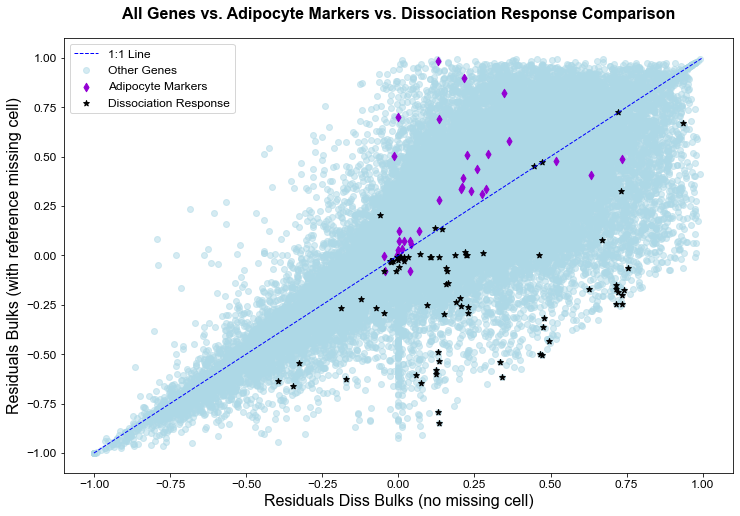

In [123]:
# Create a scatter plot with labels for multiple genes
plt.figure(figsize=(12, 8))

# Plot CIBERSORT genes
genes_of_interest = gene_ids
for gene in genes_of_interest:
    gene_data_bulks = residuals_bulks[gene]
    gene_data_dissbulks = residuals_dissbulks[gene]
    plt.scatter(gene_data_dissbulks, gene_data_bulks, alpha=0.5, c='lightblue', label='Other Genes' if gene == genes_of_interest[0] else "")

# Plot Adipocyte markers
for gene in adip_markers:
    gene_data_bulks = residuals_bulks[gene]
    gene_data_dissbulks = residuals_dissbulks[gene]
    plt.scatter(gene_data_dissbulks, gene_data_bulks, alpha=1, c='darkviolet', marker='d', label='Adipocyte Markers' if gene == adip_markers[0] else "")

# Plot Dissociation Response genes
for gene in diss_response:
    gene_data_bulks = residuals_bulks[gene]
    gene_data_dissbulks = residuals_dissbulks[gene]
    plt.scatter(gene_data_dissbulks, gene_data_bulks, alpha=1, c='black', marker='*', label='Dissociation Response' if gene == diss_response[0] else "")

# Plot 1:1 Line
plt.plot([-1, 1], [-1, 1], label='1:1 Line', color='blue', linewidth=1, linestyle='--')

# Set axis labels and title
plt.title('All Genes vs. Adipocyte Markers vs. Dissociation Response Comparison', fontsize=16, fontname='Arial', fontweight='bold', x=0.5, y=1.03)
plt.ylabel('Residuals Bulks (with reference missing cell)', fontsize=16, fontname='Arial')
plt.xlabel('Residuals Diss Bulks (no missing cell)', fontsize=16, fontname='Arial')

# Add legend
plt.legend()

# Show the plot
plt.show()

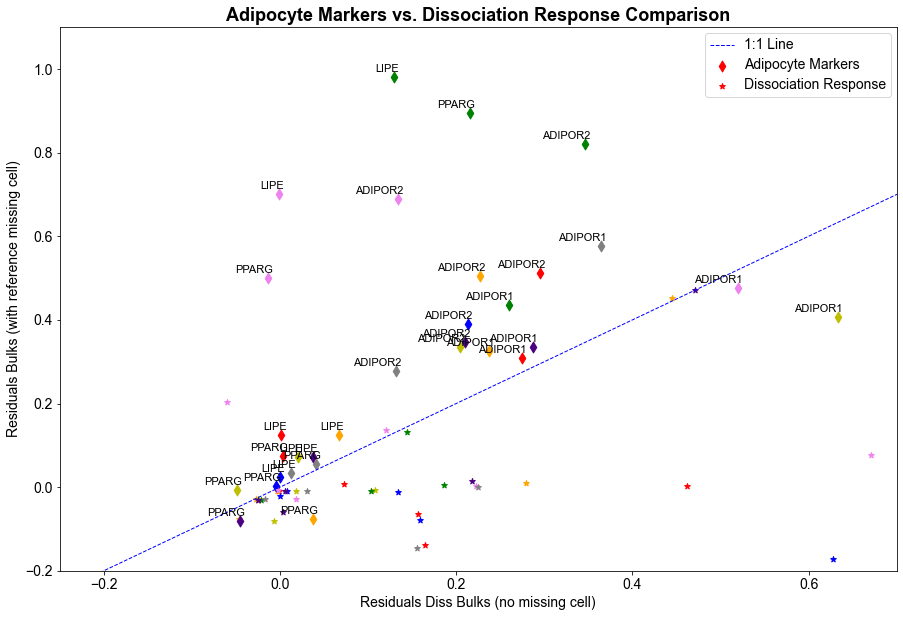

In [124]:

# Assuming `row_indices` contains the row indices of your samples
row_indices = np.tile(range(1, 9), 2)

# Define custom colors
custom_colors = ['r', 'orange', 'y', 'g', 'b', 'indigo', 'violet', 'grey']

# Create a custom colormap
cmap_custom = mcolors.ListedColormap(custom_colors)
marker_size = 100

# Create a scatter plot with labels for multiple genes
plt.figure(figsize=(15, 10))

# Get unique colors for each sample using the previously defined custom colormap
unique_colors = mcolors.ListedColormap(custom_colors)(np.arange(len(residuals_bulks)))

# Plot each gene for both bulks and dissbulks
for sample_idx, sample_color in enumerate(unique_colors):

    # Plot Adipocyte markers
    for gene in adip_markers:
        gene_data_bulks = residuals_bulks.at[sample_idx, gene]
        gene_data_dissbulks = residuals_dissbulks.at[sample_idx, gene]
        marker_size = 60  # Increase size for the first Adipocyte marker
        plt.scatter(gene_data_dissbulks, gene_data_bulks, alpha=1, c=[sample_color], marker='d', s=marker_size,
                    label='Adipocyte Markers' if gene == adip_markers[0] and sample_idx == 0 else "")
        plt.annotate(str(gene), (gene_data_dissbulks, gene_data_bulks), textcoords="offset points", xytext=(5, 5),
                     ha='right', fontsize=11)

    # Plot Dissociation Response genes
    for gene in diss_response:
        gene_data_bulks = residuals_bulks.at[sample_idx, gene]
        gene_data_dissbulks = residuals_dissbulks.at[sample_idx, gene]
        plt.scatter(gene_data_dissbulks, gene_data_bulks, alpha=1, c=[sample_color], marker='*',
                    label='Dissociation Response' if gene == diss_response[0] and sample_idx == 0 else "")

# Plot 1:1 Line
plt.plot([-1, 1], [-1, 1], label='1:1 Line', color='blue', linewidth=1, linestyle='--')

# Set axis labels and title
plt.title('Adipocyte Markers vs. Dissociation Response Comparison', fontsize=18, fontname='Arial', fontweight='bold')
plt.ylabel('Residuals Bulks (with reference missing cell)', fontsize=14, fontname='Arial')
plt.xlabel('Residuals Diss Bulks (no missing cell)', fontsize=14, fontname='Arial')

# Add legend
legend = plt.legend()
plt.xlim(-0.25, .7)
plt.ylim(-0.2, 1.1)

# Set font size and font family for legend
for text in legend.get_texts():
    text.set_fontsize(14)
    text.set_fontname('Arial')

# Set font size for tick labels
plt.xticks(fontsize=14, fontname='Arial')
plt.yticks(fontsize=14, fontname='Arial')

# Show the plot
plt.show()


# Distributions of Residuals

Classic (-rRNA) Bulks and Dissociated (-rRNA) Bulks

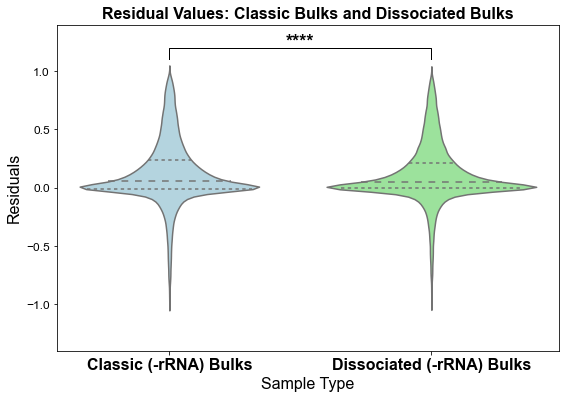

In [125]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
classic_bulks_values = residuals_bulks.values.flatten()
dissociated_bulks_values = residuals_dissbulks.values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Classic Bulks'] * len(classic_bulks_values) +
                                  ['Dissociated Bulks'] * len(dissociated_bulks_values),
                   'Residuals': np.concatenate([classic_bulks_values, dissociated_bulks_values])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals', data=df, ax=ax, inner='quartile', palette=['lightblue', 'lightgreen'])

# Add labels to the x-axis
ax.set_xticklabels(['Classic (-rRNA) Bulks', 'Dissociated (-rRNA) Bulks'], fontsize=16, fontweight='bold', fontname='Arial')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = stats.wilcoxon(classic_bulks_values, dissociated_bulks_values)

# Set a significance level (e.g., 0.05)
alpha = 0.05

# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value)} (p < 0.05)"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = 1.1, 1.2
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2-0.03, asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value)} (p < 0.05)"
    # No asterisks for non-significant results

# Add the significance label and the name of the statistical test to the plot
#plt.text(0.5, .65, f'Wilcoxon T-Test: {significance_label}', fontsize=12, fontweight='bold', fontname='Arial')

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals', fontsize=16, fontname='Arial')
plt.title('Residual Values: Classic Bulks and Dissociated Bulks', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.4)
plt.show()


Dissociated (polyA) Bulks and Dissociated (-rRNA) Bulks

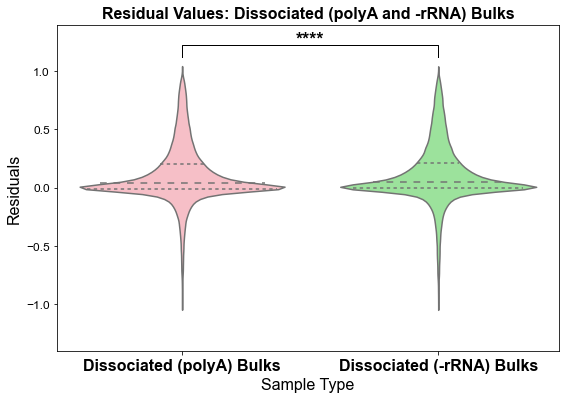

In [126]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
classic_bulks_values = residuals_disspolyabulks.values.flatten()
dissociated_bulks_values = residuals_dissbulks.values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Classic Bulks'] * len(classic_bulks_values) +
                                  ['Dissociated Bulks'] * len(dissociated_bulks_values),
                   'Residuals': np.concatenate([classic_bulks_values, dissociated_bulks_values])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals', data=df, ax=ax, inner='quartile', palette=['lightpink', 'lightgreen'])

# Add labels to the x-axis
ax.set_xticklabels(['Dissociated (polyA) Bulks', 'Dissociated (-rRNA) Bulks'], fontsize=16, fontname='Arial', fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = stats.wilcoxon(classic_bulks_values, dissociated_bulks_values)

# Set a significance level (e.g., 0.05)
alpha = 0.05

# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value)} (p < 0.05)"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = 1.12, 1.22  # Adjusted higher y-coordinate
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2-0.03, asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value)} (p > 0.05)"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = 1.12, 1.22  # Adjusted higher y-coordinate
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2-0.03, "N.S.", ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals', fontsize=16, fontname='Arial')
plt.title('Residual Values: Dissociated (polyA and -rRNA) Bulks', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.4)
plt.show()


**Distributions: Only Adipocyte Markers**

Classic (-rRNA) Bulks and Dissociated (-rRNA) Bulks

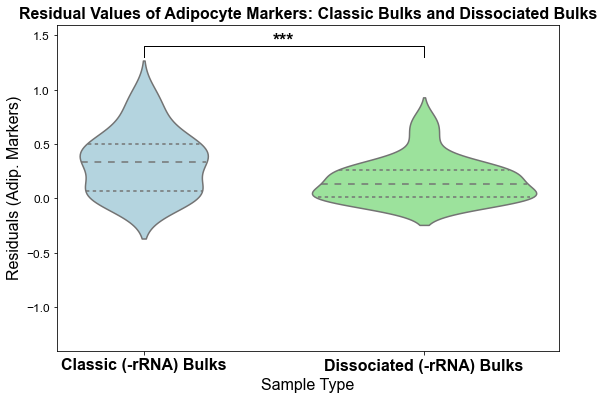

In [127]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
adip_intersect = np.intersect1d(residuals_bulks.columns, adip_markers)

classic_bulks_values = residuals_bulks[adip_intersect].values.flatten()
dissociated_bulks_values = residuals_dissbulks[adip_intersect].values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Classic Bulks'] * len(classic_bulks_values) +
                                  ['Dissociated Bulks'] * len(dissociated_bulks_values),
                   'Residuals (Adip. Markers)': np.concatenate([classic_bulks_values, dissociated_bulks_values])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals (Adip. Markers)', data=df, ax=ax, inner='quartile', palette=['lightblue', 'lightgreen'])

# Add labels to the x-axis
ax.set_xticklabels(['Classic (-rRNA) Bulks', 'Dissociated (-rRNA) Bulks'], fontsize=16, fontname='Arial', fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = stats.wilcoxon(classic_bulks_values, dissociated_bulks_values)

# Set a significance level (e.g., 0.05)
alpha = 0.05

# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)} (p < 0.05)"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = 1.3, 1.4  # Adjusted higher y-coordinate
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2-0.03, asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = 1.3, 1.4  # Adjusted higher y-coordinate
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2, s='N.S.', ha='center', va='bottom', fontsize=12, fontname='Arial')

# Add the significance label and the name of the statistical test to the plot
#plt.text(0.2, 0.9, f'Wilcoxon T-Test: {significance_label}', fontsize=12, fontweight='bold', fontname='Arial')

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals (Adip. Markers)', fontsize=16, fontname='Arial')
plt.title('Residual Values of Adipocyte Markers: Classic Bulks and Dissociated Bulks', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.6)
plt.show()


Dissociated (-rRNA) Bulks and Dissociated (polyA) Bulks

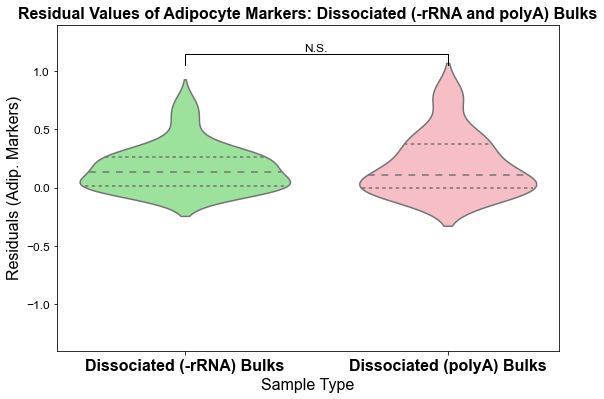

In [128]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
adip_intersect = np.intersect1d(residuals_bulks.columns, adip_markers)

classic_bulks_values = residuals_dissbulks[adip_intersect].values.flatten()
dissociated_bulks_values = residuals_disspolyabulks[adip_intersect].values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Classic Bulks'] * len(classic_bulks_values) +
                                  ['Dissociated Bulks'] * len(dissociated_bulks_values),
                   'Residuals (Adip. Markers)': np.concatenate([classic_bulks_values, dissociated_bulks_values])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals (Adip. Markers)', data=df, ax=ax, inner='quartile', palette=['lightgreen', 'lightpink'])

# Add labels to the x-axis
ax.set_xticklabels(['Dissociated (-rRNA) Bulks', 'Dissociated (polyA) Bulks'], fontsize=16, fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = stats.wilcoxon(classic_bulks_values, dissociated_bulks_values)

# Set a significance level (e.g., 0.05)
alpha = 0.05

# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)} (p < 0.05)"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = 1.2, 1.3  # Adjusted higher y-coordinate
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, (x1 + x2) / 2, x2, x2], [y1, y2, y2 + 0.1, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2 , asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = 1.05, 1.15  # Adjusted higher y-coordinate
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2, s='N.S.', ha='center', va='bottom', fontsize=12, fontname='Arial')
    # No asterisks for non-significant results

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals (Adip. Markers)', fontsize=16, fontname='Arial')
plt.title('Residual Values of Adipocyte Markers: Dissociated (-rRNA and polyA) Bulks', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.4)
plt.show()


Classic (-rRNA) Bulks and Dissociated (polyA) Bulks

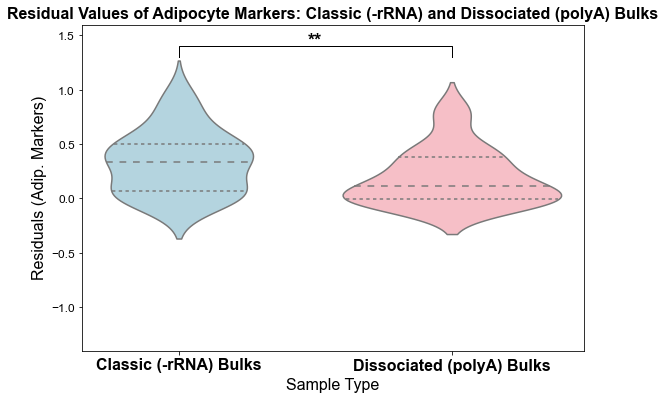

In [129]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
adip_intersect = np.intersect1d(residuals_bulks.columns, adip_markers)

classic_bulks_values = residuals_bulks[adip_intersect].values.flatten()
dissociated_bulks_values = residuals_disspolyabulks[adip_intersect].values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Classic Bulks'] * len(classic_bulks_values) +
                                  ['Dissociated Bulks'] * len(dissociated_bulks_values),
                   'Residuals (Adip. Markers)': np.concatenate([classic_bulks_values, dissociated_bulks_values])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals (Adip. Markers)', data=df, ax=ax, inner='quartile', palette=['lightblue', 'lightpink'])

# Add labels to the x-axis
ax.set_xticklabels(['Classic (-rRNA) Bulks', 'Dissociated (polyA) Bulks'], fontsize=16, fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = stats.wilcoxon(classic_bulks_values, dissociated_bulks_values)

# Set a significance level (e.g., 0.05)
alpha = 0.05

# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)} (p < 0.05)"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = 1.3, 1.4 # Adjusted higher y-coordinate
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, (x1 + x2) / 2, x2, x2], [y1, y2, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2-0.03 , asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = 1.3, 1.4 # Adjusted higher y-coordinate
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2, s='N.S.', ha='center', va='bottom', fontsize=12, fontname='Arial')
    # No asterisks for non-significant results

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals (Adip. Markers)', fontsize=16, fontname='Arial')
plt.title('Residual Values of Adipocyte Markers: Classic (-rRNA) and Dissociated (polyA) Bulks', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.6)
plt.show()

**Distributions: Only Dissociation Markers**

Classic (-rRNA) Bulks and Dissociated (-rRNA) Bulks

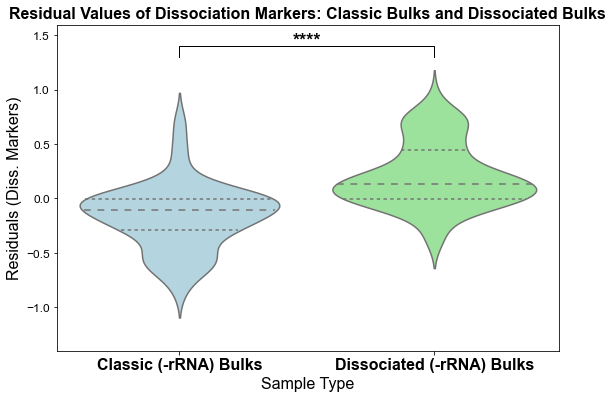

In [130]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
adip_intersect = np.intersect1d(residuals_bulks.columns, diss_response)

classic_bulks_values = residuals_bulks[adip_intersect].values.flatten()
dissociated_bulks_values = residuals_dissbulks[adip_intersect].values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Classic Bulks'] * len(classic_bulks_values) +
                                  ['Dissociated Bulks'] * len(dissociated_bulks_values),
                   'Residuals (Diss. Markers)': np.concatenate([classic_bulks_values, dissociated_bulks_values])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals (Diss. Markers)', data=df, ax=ax, inner='quartile', palette=['lightblue', 'lightgreen'])

# Add labels to the x-axis
ax.set_xticklabels(['Classic (-rRNA) Bulks', 'Dissociated (-rRNA) Bulks'], fontsize=16, fontname='Arial', fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = stats.wilcoxon(classic_bulks_values, dissociated_bulks_values)

# Set a significance level (e.g., 0.05)
alpha = 0.05

# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)} (p < 0.05)"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = 1.3, 1.4  # Adjusted higher y-coordinate
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2-0.03, asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = 1.3, 1.4 # Adjusted higher y-coordinate
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2, s='N.S.', ha='center', va='bottom', fontsize=12, fontname='Arial')
    # No asterisks for non-significant results

# Add the significance label and the name of the statistical test to the plot
#plt.text(0.2, 0.9, f'Wilcoxon T-Test: {significance_label}', fontsize=12, fontweight='bold', fontname='Arial')

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals (Diss. Markers)', fontsize=16, fontname='Arial')
plt.title('Residual Values of Dissociation Markers: Classic Bulks and Dissociated Bulks', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.6)
plt.show()


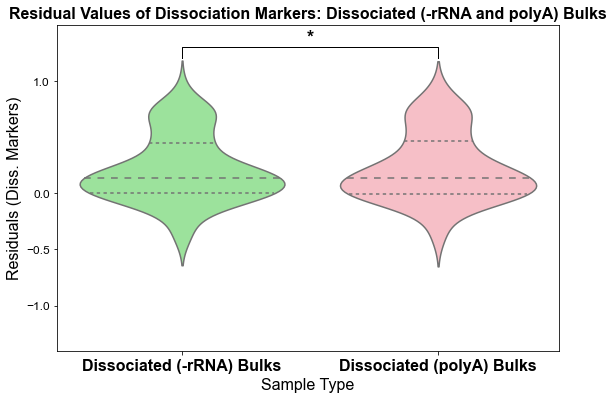

In [131]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
adip_intersect = np.intersect1d(residuals_bulks.columns, diss_response)

classic_bulks_values = residuals_dissbulks[adip_intersect].values.flatten()
dissociated_bulks_values = residuals_disspolyabulks[adip_intersect].values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Classic Bulks'] * len(classic_bulks_values) +
                                  ['Dissociated Bulks'] * len(dissociated_bulks_values),
                   'Residuals (Adip. Markers)': np.concatenate([classic_bulks_values, dissociated_bulks_values])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals (Adip. Markers)', data=df, ax=ax, inner='quartile', palette=['lightgreen', 'lightpink'])

# Add labels to the x-axis
ax.set_xticklabels(['Dissociated (-rRNA) Bulks', 'Dissociated (polyA) Bulks'], fontsize=16, fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = stats.wilcoxon(classic_bulks_values, dissociated_bulks_values)

# Set a significance level (e.g., 0.05)
alpha = 0.05

# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)} (p < 0.05)"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = 1.2, 1.3  # Adjusted higher y-coordinate
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, (x1 + x2) / 2, x2, x2], [y1, y2, y2 , y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2 , asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = 1.1,1.2
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2, s='N.S.', ha='center', va='bottom', fontsize=12, fontname='Arial')
    # No asterisks for non-significant results

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals (Diss. Markers)', fontsize=16, fontname='Arial')
plt.title('Residual Values of Dissociation Markers: Dissociated (-rRNA and polyA) Bulks', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.5)
plt.yticks([-1,-0.5,0.0,1])
plt.show()

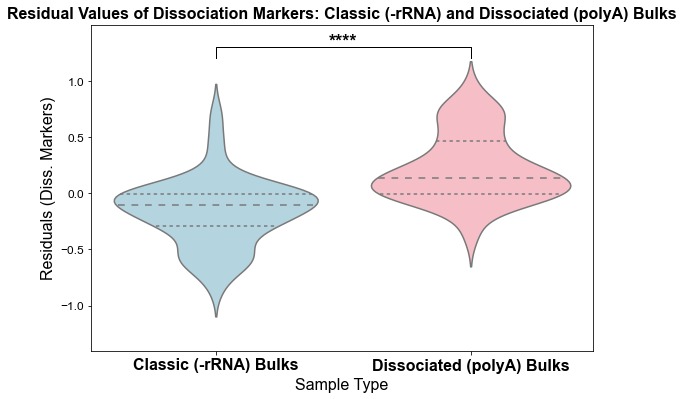

In [132]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
adip_intersect = np.intersect1d(residuals_bulks.columns, diss_response)

classic_bulks_values = residuals_bulks[adip_intersect].values.flatten()
dissociated_bulks_values = residuals_disspolyabulks[adip_intersect].values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Classic Bulks'] * len(classic_bulks_values) +
                                  ['Dissociated Bulks'] * len(dissociated_bulks_values),
                   'Residuals (Diss. Markers)': np.concatenate([classic_bulks_values, dissociated_bulks_values])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals (Diss. Markers)', data=df, ax=ax, inner='quartile', palette=['lightblue', 'lightpink'])

# Add labels to the x-axis
ax.set_xticklabels(['Classic (-rRNA) Bulks', 'Dissociated (polyA) Bulks'], fontsize=16, fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = stats.wilcoxon(classic_bulks_values, dissociated_bulks_values)

# Set a significance level (e.g., 0.05)
alpha = 0.05

# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)} (p < 0.05)"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = 1.2, 1.3 # Adjusted higher y-coordinate
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, (x1 + x2) / 2, x2, x2], [y1, y2, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2-0.03 , asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = 1.1, 1.2
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2, s='N.S.', ha='center', va='bottom', fontsize=12, fontname='Arial')
    # No asterisks for non-significant results
    # No asterisks for non-significant results

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals (Diss. Markers)', fontsize=16, fontname='Arial')
plt.title('Residual Values of Dissociation Markers: Classic (-rRNA) and Dissociated (polyA) Bulks', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.5)
plt.yticks([-1.0, -0.5, 0.0, 0.5, 1])
plt.show()

## PCA

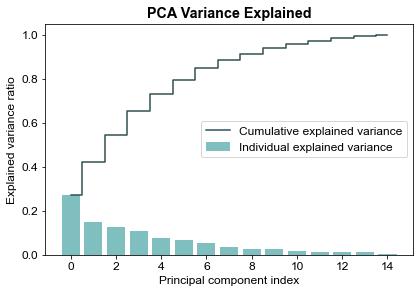

In [133]:
# Set font to Arial
font = {'family': 'Arial', 'weight': 'normal', 'size': 12}
plt.rc('font', **font)
num_pca_components_combo = 15
pca_res = dict()
df = residuals_combo  # transposing to get length of genes instead of samples
pca_fit = PCA(n_components=num_pca_components_combo)
pca_results = pca_fit.fit_transform(df.values)

exp_var_pca = pca_fit.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

# Plot variance explained
plt.bar(range(0, len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', color='teal', label='Individual explained variance')
plt.step(range(0, len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid', color='darkslategrey', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.title("PCA Variance Explained", fontweight='bold')
plt.show()


In [134]:
# Separate the first and last 8 samples
first_half_samples = pca_results[:8]
second_half_samples = pca_results[-8:]

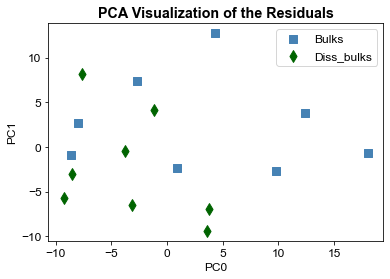

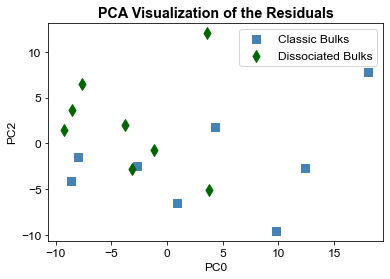

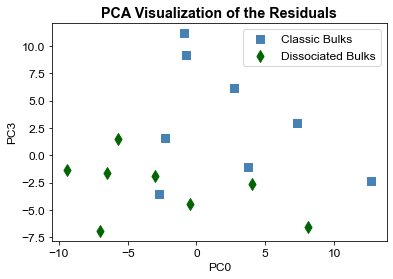

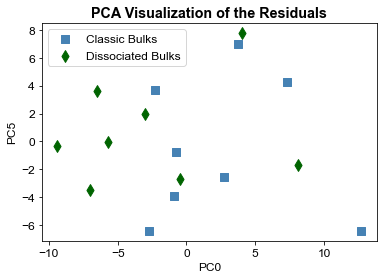

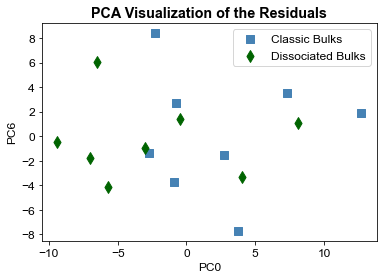

In [135]:
marker_size = 70

# Set font to Arial
font = {'family': 'Arial', 'weight': 'normal', 'size': 12}
plt.rc('font', **font)

# PCA Visualization of the Residuals
plt.scatter(first_half_samples[:, 0], first_half_samples[:, 1], label="Bulks", c='steelblue', marker='s', s=marker_size)
plt.scatter(second_half_samples[:, 0], second_half_samples[:, 1], label="Diss_bulks", c='darkgreen', marker='d', s=marker_size)
plt.legend()
plt.title("PCA Visualization of the Residuals", fontweight='bold')
plt.xlabel("PC0")
plt.ylabel("PC1")
plt.show()

# PCA Visualization
plt.scatter(first_half_samples[:, 0], first_half_samples[:, 2], label="Classic Bulks", c='steelblue', marker='s', s=marker_size)
plt.scatter(second_half_samples[:, 0], second_half_samples[:, 2], label="Dissociated Bulks", c='darkgreen', marker='d', s=marker_size)
plt.legend()
plt.title("PCA Visualization of the Residuals", fontweight='bold')
plt.xlabel("PC0")
plt.ylabel("PC2")
plt.show()

# PCA Visualization
plt.scatter(first_half_samples[:, 1], first_half_samples[:, 3], label="Classic Bulks", c='steelblue', marker='s', s=marker_size)
plt.scatter(second_half_samples[:, 1], second_half_samples[:, 3], label="Dissociated Bulks", c='darkgreen', marker='d', s=marker_size)
plt.legend()
plt.title("PCA Visualization of the Residuals", fontweight='bold')
plt.xlabel("PC0")
plt.ylabel("PC3")
plt.show()

# PCA Visualization
plt.scatter(first_half_samples[:, 1], first_half_samples[:, 4], label="Classic Bulks", c='steelblue', marker='s', s=marker_size)
plt.scatter(second_half_samples[:, 1], second_half_samples[:, 4], label="Dissociated Bulks", c='darkgreen', marker='d', s=marker_size)
plt.legend()
plt.title("PCA Visualization of the Residuals", fontweight='bold')
plt.xlabel("PC0")
plt.ylabel("PC5")
plt.show()

# PCA Visualization
plt.scatter(first_half_samples[:, 1], first_half_samples[:, 5], label="Classic Bulks", c='steelblue', marker='s', s=marker_size)
plt.scatter(second_half_samples[:, 1], second_half_samples[:, 5], label="Dissociated Bulks", c='darkgreen', marker='d', s=marker_size)
plt.legend()
plt.title("PCA Visualization of the Residuals", fontweight='bold')
plt.xlabel("PC0")
plt.ylabel("PC6")
plt.show()


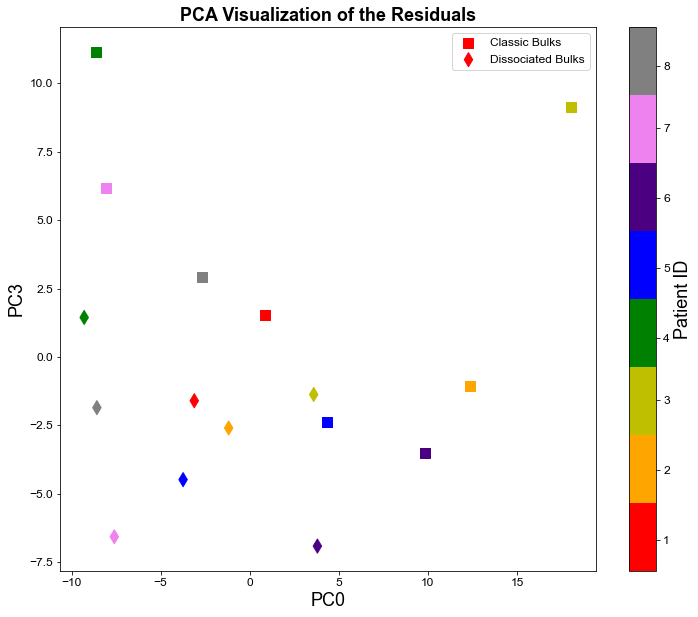

In [162]:

# Assuming `row_indices` contains the row indices of your samples
row_indices = np.tile(range(1, 9), 2)
plt.figure(figsize = (12,10))
# Define custom colors
custom_colors = ['r', 'orange', 'y', 'g', 'b', 'indigo', 'violet', 'grey']

# Create a custom colormap
cmap_custom = mcolors.ListedColormap(custom_colors)
marker_size = 100

# PCA Visualization
scatter1 = plt.scatter(first_half_samples[:, 0], first_half_samples[:, 3], label="Classic Bulks", c=row_indices[:len(first_half_samples)], 
                            cmap=cmap_custom, marker='s', s=marker_size)
scatter2 = plt.scatter(second_half_samples[:, 0], second_half_samples[:, 3], label="Dissociated Bulks", c=row_indices[len(first_half_samples):], 
                            cmap=cmap_custom, marker='d', s=marker_size)

# Add colorbar for reference
cbar = plt.colorbar()
cbar.set_label('Patient ID', fontsize=18)

# Adjust colorbar ticks to be centered between colors
cbar.set_ticks([1.4, 2.3 ,3.2 ,4, 4.9 , 5.8 ,6.7 ,7.5])
cbar.set_ticklabels([1,2,3,4,5,6,7,8])

# Change the color of the little marker in the legend
# Change the color of the marker in the legend using a custom handler
legend = plt.legend()

plt.title("PCA Visualization of the Residuals", fontweight='bold', fontsize=18, fontname='Arial')
plt.xlabel("PC0", fontsize=18, fontname='Arial')
plt.ylabel("PC3", fontsize=18, fontname='Arial')
plt.show()


In [137]:
# 'residuals_all.columns' contains the names of the genes
comp_genes= []
pca_genes = dict()
# Iterate through each component
for component_idx in range(num_pca_components_combo):
    # Calculate loadings for the current component
    loadings = pca_fit.components_.T * np.sqrt(pca_fit.explained_variance_)

    # Sort genes by their influence on the current component
    sorted_genes = residuals_combo.columns[np.argsort(loadings[:, component_idx])]

    # Visualize the top N genes that contribute the most to the current component
    N = 10  
    top_genes = sorted_genes[-N:]

    print(f"Genes contributing the most to Principal Component {component_idx + 1}:")
    print(top_genes)

    pca_genes[component_idx] = top_genes
    comp_genes = np.append(comp_genes, top_genes)


Genes contributing the most to Principal Component 1:
Index(['ASPM', 'ESRP1', 'LGR5', 'CLDN7', 'DMKN', 'SPINT2', 'EPS8L1', 'KLK11',
       'TMPRSS4', 'VTCN1'],
      dtype='object')
Genes contributing the most to Principal Component 2:
Index(['NCKAP1L', 'GBP5', 'SYK', 'CD84', 'SIGLEC1', 'LILRB4', 'CIITA', 'FPR3',
       'SAMD9L', 'FYB1'],
      dtype='object')
Genes contributing the most to Principal Component 3:
Index(['IFIT3', 'AC116366.1', 'ALPK3', 'C5orf56', 'TNF', 'SLC15A3', 'RSAD2',
       'ISG15', 'IFIT2', 'PIGR'],
      dtype='object')
Genes contributing the most to Principal Component 4:
Index(['MMD', 'TMEM132C', 'HP', 'SAA1', 'GPAM', 'PLXNA4', 'FKBP5', 'LIMCH1',
       'ANK2', 'CLSTN2'],
      dtype='object')
Genes contributing the most to Principal Component 5:
Index(['INHBA', 'ZBTB16', 'PRRX1', 'PALLD', 'FAP', 'GEM', 'BHLHE41', 'NNMT',
       'UNC5B', 'KIF26B'],
      dtype='object')
Genes contributing the most to Principal Component 6:
Index(['CTHRC1', 'NUP210', 'GRIK3', '

In [138]:
pca_genes[4]

Index(['INHBA', 'ZBTB16', 'PRRX1', 'PALLD', 'FAP', 'GEM', 'BHLHE41', 'NNMT',
       'UNC5B', 'KIF26B'],
      dtype='object')

In [139]:
int_adip =[]
int_eryth = []
int_diss = []
for component in pca_genes:
    for gene in pca_genes[component]:
        if gene in adip_markers:    
            print(f"{gene} adip")
            print(component)  
        if gene in diss_response:
            print(f"{gene} dissociation") 
            print(component)      

IL1B dissociation
7
PMAIP1 dissociation
10


## NMF

Analyzing how close to negative the distributions of each residual are:

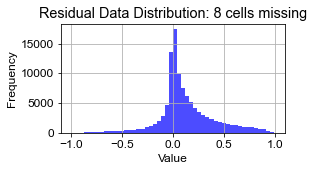

In [140]:
data = residuals_bulks.values
plt.figure(figsize=(4, 2)) 
plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
plt.title(f'Residual Data Distribution: {num} cells missing')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

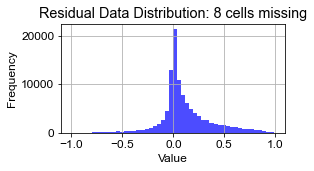

In [141]:
data = residuals_dissbulks.values
plt.figure(figsize=(4, 2)) 
plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
plt.title(f'Residual Data Distribution: {num} cells missing')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Shifting distributions according to above plots, and calculating NMF:

1.0000000000000007


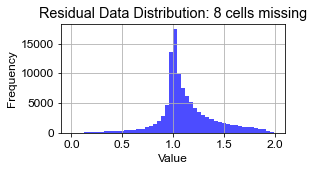

In [142]:
residuals_bulks_shift=residuals_bulks
if nmf_cut == "minimum_value":
    #calculate value to shift distributions minimally:
    min_val = abs(np.min(np.min(residuals_bulks)))
    print(min_val)
    residuals_bulks_shift= residuals_bulks + min_val
elif nmf_cut == "at_0":
    #cutting distribution at 0
    residuals_bulks_shift[residuals_bulks_shift.values <= 0] = 0
data = residuals_bulks_shift.values
plt.figure(figsize=(4, 2)) 
plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
plt.title(f'Residual Data Distribution: {num} cells missing')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

1.0000000000000007


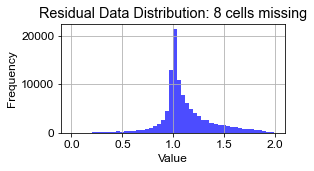

In [143]:
residuals_dissbulks_shift=residuals_dissbulks
if nmf_cut == "minimum_value":
    #calculate value to shift distributions minimally:
    min_val = abs(np.min(np.min(residuals_dissbulks)))
    print(min_val)
    residuals_dissbulks_shift= residuals_dissbulks + min_val
elif nmf_cut == "at_0":
    #cutting distribution at 0
    residuals_dissbulks_shift[residuals_dissbulks_shift.values <= 0] = 0
data = residuals_dissbulks_shift.values
plt.figure(figsize=(4, 2)) 
plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
plt.title(f'Residual Data Distribution: {num} cells missing')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

1.0000000000000009


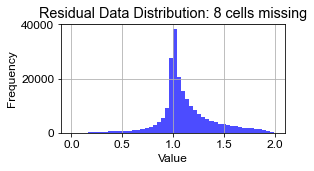

In [144]:
residuals_combo_shift=residuals_combo
if nmf_cut == "minimum_value":
    #calculate value to shift distributions minimcomboy:
    min_val = abs(np.min(np.min(residuals_combo)))
    print(min_val)
    residuals_combo_shift= residuals_combo + min_val
elif nmf_cut == "at_0":
    #cutting distribution at 0
    residuals_combo_shift[residuals_combo_shift.values <= 0] = 0
data = residuals_combo_shift.values
plt.figure(figsize=(4, 2)) 
plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
plt.title(f'Residual Data Distribution: {num} cells missing')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

The combined residuals (classic and dissociated)

In [145]:
#nmf on residual 1
num_nmf_comp_combo = 4
nmf = NMF(n_components = num_nmf_comp_combo, init='nndsvd', max_iter=20000)
res_nmf_df = nmf.fit_transform(residuals_combo_shift)
res_nmf_df = pd.DataFrame(res_nmf_df)
res_nmf_combo = res_nmf_df
components_combo = pd.DataFrame(nmf.components_)
components_combo.columns = gene_ids
components_combo

,A1BG,A1BG-AS1,A2M,A2M-AS1,A4GALT,AAAS,AACS,AAGAB,AAK1,AAMDC,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,0.080619,0.099873,0.152290,0.100913,0.111019,0.136166,0.139796,0.116602,0.136824,0.065081,...,0.106028,0.127558,0.103977,0.116415,0.100249,0.100972,0.117343,0.165290,0.142447,0.155244
1,0.068564,0.084499,0.127065,0.082941,0.078413,0.117371,0.100297,0.096154,0.118303,0.058200,...,0.084478,0.105283,0.089078,0.107567,0.088869,0.088638,0.158287,0.103134,0.065299,0.146287
2,0.071991,0.095495,0.148971,0.101649,0.095025,0.117326,0.105580,0.115875,0.124330,0.063004,...,0.105937,0.102324,0.101806,0.086331,0.101878,0.099316,0.100348,0.141972,0.182579,0.197695
3,0.080388,0.094646,0.148385,0.097460,0.129812,0.087483,0.105524,0.097420,0.019621,0.052602,...,0.096794,0.078510,0.088464,0.085558,0.115883,0.142996,0.150823,0.080672,0.151193,0.173250


In [146]:
# Separate the data into "classic bulks" and "dissociated bulks"
df = res_nmf_combo
classic_bulks = df.iloc[:8, :]
dissociated_bulks = df.iloc[8:, :]

# Perform t-test for each component
results = pd.DataFrame(columns=['Component', 'T-Statistic', 'P-Value'])

for column in df.columns:
    t_statistic, p_value = stats.ttest_ind(classic_bulks[column], dissociated_bulks[column])
    results = results.append({'Component': column, 'T-Statistic': t_statistic, 'P-Value': p_value}, ignore_index=True)

# Print the results
print(results)

# Identify components with significantly different means
significantly_different = results[results['P-Value'] < 0.05]
print("Components with significantly different means:")
print(significantly_different)

   Component  T-Statistic   P-Value
0        0.0     0.088260  0.930920
1        1.0     1.458008  0.166905
2        2.0     0.104759  0.918053
3        3.0    -3.948519  0.001456
Components with significantly different means:
   Component  T-Statistic   P-Value
3        3.0    -3.948519  0.001456


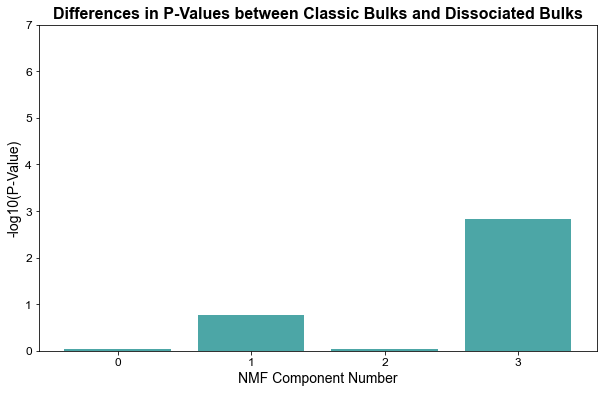

In [147]:
# Bar plot for each component
plt.figure(figsize=(10, 6))
plt.bar(results['Component'], -np.log10(results['P-Value']), color='teal', alpha=0.7)

plt.xlabel('NMF Component Number', fontsize=14, fontname='Arial')
plt.ylabel('-log10(P-Value)', fontsize=14, fontname='Arial')
plt.title('Differences in P-Values between Classic Bulks and Dissociated Bulks', fontsize=16, fontname='Arial', fontweight='bold')
plt.xticks([0,1,2,3])
plt.ylim(0,7)
plt.show()

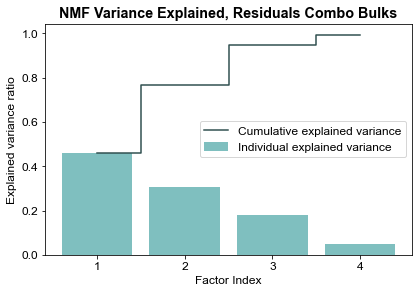

In [148]:
# W and H are your NMF results
V = residuals_combo_shift.values
W = res_nmf_combo.values
H = components_combo.values # Solve for H using least squares

# Calculate the explained variance for each component
explained_variance = []
for i in range(W.shape[1]):
    WH = np.dot(W[:, :i+1], H[:i+1, :])
    explained_variance.append(1 - np.linalg.norm(V - WH, 'fro')**2 / np.linalg.norm(V, 'fro')**2)

cum_sum = explained_variance

indiv_variance =  [cum_sum[0], 
                cum_sum[1] - cum_sum[0],
                cum_sum[2]- cum_sum[1],
                cum_sum[3] - cum_sum[2]]
#                cum_sum[4] - cum_sum[3] ]



## plot variance explained
plt.bar(range(1,len(indiv_variance)+1), indiv_variance, alpha=0.5, align='center', label='Individual explained variance',color='teal')
plt.step(range(1,len(cum_sum)+1), cum_sum, where='mid',label='Cumulative explained variance', color='darkslategrey')
plt.ylabel('Explained variance ratio', fontname="Arial")
plt.xlabel('Factor Index', fontname="Arial")
plt.legend(loc='best')
plt.tight_layout()
plt.xticks(range(1,len(res_nmf_combo.columns)+1))
plt.title(f"NMF Variance Explained, Residuals Combo Bulks", fontweight='bold', fontname="Arial")
plt.show()

In [149]:
W = res_nmf_combo.values
H = components_combo.values

comp_genes = dict()
num_components = num_nmf_comp_combo
# Iterate through each component
for component_idx in range(num_components):
    # Sort genes by their influence on the current component
    sorted_genes = residuals_combo.columns[np.argsort(H[component_idx])]

    # Visualize the top N genes that contribute the most to the current component
    N = 10
    top_genes = sorted_genes[-N:]

    print(f"Genes contributing the most to NMF Component {component_idx + 1}:")
    print(top_genes)
 
    comp_genes[component_idx] =top_genes

Genes contributing the most to NMF Component 1:
Index(['CYBRD1', 'COL14A1', 'FKBP9', 'PHLDB1', 'F13A1', 'LAMA2', 'SEMA4C',
       'PTGIS', 'KANK2', 'PPL'],
      dtype='object')
Genes contributing the most to NMF Component 2:
Index(['CPSF1', 'ESRP1', 'ALS2CL', 'WDR91', 'CELSR1', 'HID1', 'TMEM63A',
       'EPS8L1', 'TMPRSS4', 'VTCN1'],
      dtype='object')
Genes contributing the most to NMF Component 3:
Index(['PLEK', 'MRC1', 'SLFN11', 'DOCK2', 'PLEKHO2', 'NCKAP1L', 'SIGLEC1',
       'CD4', 'SLCO2B1', 'CSF1R'],
      dtype='object')
Genes contributing the most to NMF Component 4:
Index(['AC116366.1', 'DUSP4', 'LIF', 'RELT', 'KLHL21', 'GRASP', 'SPHK1',
       'NLRP3', 'AC092053.3', 'SIK1B'],
      dtype='object')


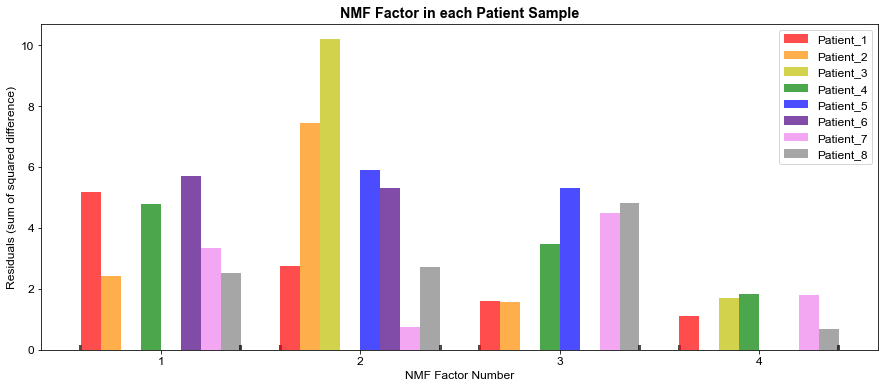

In [150]:
pt1_values = res_nmf_combo.loc[0].values
pt2_values = res_nmf_combo.loc[1].values
pt3_values = res_nmf_combo.loc[2].values
pt4_values = res_nmf_combo.loc[3].values
pt5_values = res_nmf_combo.loc[4].values
pt6_values = res_nmf_combo.loc[5].values
pt7_values = res_nmf_combo.loc[6].values
pt8_values = res_nmf_combo.loc[7].values

# Define custom colors
custom_colors = ['r', 'darkorange', 'y', 'g', 'b', 'indigo', 'violet', 'grey']

# Create x-coordinates for the bars
x_coordinates = np.arange(len(pt1_values)) + 1

# Width of each bar
bar_width = 0.1

# Set the font to Arial for all text
plt.rcParams['font.family'] = 'Arial'

plt.figure(figsize=(15, 6))

# Plot "Classic Bulks" residuals
plt.bar(x_coordinates - (bar_width * 4), 0.15, width=0.015, alpha=0.7, color='black')
plt.bar(x_coordinates - (bar_width * 3.5), pt1_values, width=bar_width, alpha=0.7, label='Patient_1', color=custom_colors[0])

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates - (bar_width * 2.5), pt2_values, width=bar_width, alpha=0.7, label='Patient_2', color=custom_colors[1])

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates - (bar_width * 1.5), pt3_values, width=bar_width, alpha=0.7, label='Patient_3', color=custom_colors[2])

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates - (bar_width * 0.5), pt4_values, width=bar_width, alpha=0.7, label='Patient_4', color=custom_colors[3])

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates + (bar_width * 0.5), pt5_values, width=bar_width, alpha=0.7, label='Patient_5', color=custom_colors[4])

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates + (bar_width * 1.5), pt6_values, width=bar_width, alpha=0.7, label='Patient_6', color=custom_colors[5])

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates + (bar_width * 2.5), pt7_values, width=bar_width, alpha=0.7, label='Patient_7', color=custom_colors[6])

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates + (bar_width * 3.5), pt8_values, width=bar_width, alpha=0.7, label='Patient_8', color=custom_colors[7])
plt.bar(x_coordinates + (bar_width * 4), 0.15, width=0.015, alpha=0.7, color='black')
plt.xlabel('NMF Factor Number')
plt.ylabel('Residuals (sum of squared difference)')

# Set the title to bold
plt.title('NMF Factor in each Patient Sample', fontweight='bold')

plt.xticks(x_coordinates)  # Adjust x-axis labels

# Move the legend to the upper right corner
plt.legend()

plt.show()

Now dissociated bulks:

In [151]:
#nmf on residual 1
num_nmf = 5
nmf = NMF(n_components = num_nmf, init="nndsvd", max_iter=10000)
res_nmf_df = nmf.fit_transform(residuals_dissbulks_shift)
res_nmf_df = pd.DataFrame(res_nmf_df)
res_nmf_dissbulks = res_nmf_df
components_dissbulks = pd.DataFrame(nmf.components_)
components_dissbulks.columns = gene_ids
components_dissbulks

/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  warnings.warn(


,A1BG,A1BG-AS1,A2M,A2M-AS1,A4GALT,AAAS,AACS,AAGAB,AAK1,AAMDC,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,0.079338,0.096394,0.147999,0.097754,0.098256,0.133680,0.119824,0.111685,0.100165,0.061058,...,0.102104,0.117408,0.101784,0.117170,0.100734,0.104482,0.143186,0.141764,0.131623,0.142412
1,0.037125,0.047749,0.073630,0.051714,0.048829,0.054961,0.046560,0.060343,0.036299,0.028466,...,0.052600,0.047070,0.052564,0.050492,0.053849,0.058062,0.048960,0.059072,0.081246,0.094140
2,0.056763,0.065742,0.101069,0.064713,0.074378,0.070907,0.085462,0.070937,0.043301,0.041179,...,0.064805,0.066883,0.062143,0.064986,0.074684,0.086730,0.127462,0.060684,0.071896,0.121599
3,0.067070,0.085921,0.133938,0.088016,0.123587,0.085457,0.097650,0.093329,0.095225,0.056549,...,0.089956,0.082146,0.084087,0.067455,0.099683,0.111889,0.100338,0.109056,0.153738,0.175240
4,0.044063,0.055431,0.085218,0.055615,0.055183,0.067094,0.063091,0.055622,0.086521,0.037852,...,0.057173,0.065621,0.053632,0.059337,0.055480,0.052404,0.078340,0.070268,0.083220,0.106821


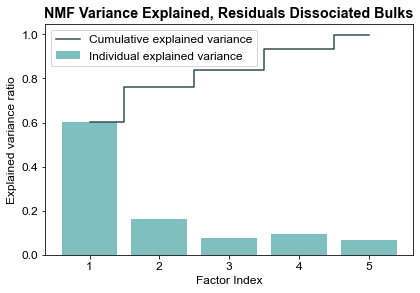

In [152]:
# W and H are your NMF results
V = residuals_dissbulks_shift.values
W = res_nmf_dissbulks.values
H = components_dissbulks.values # Solve for H using least squares

# Calculate the explained variance for each component
explained_variance = []
for i in range(W.shape[1]):
    WH = np.dot(W[:, :i+1], H[:i+1, :])
    explained_variance.append(1 - np.linalg.norm(V - WH, 'fro')**2 / np.linalg.norm(V, 'fro')**2)

cum_sum = explained_variance

indiv_variance =  [cum_sum[0], 
                cum_sum[1] - cum_sum[0],
                cum_sum[2]- cum_sum[1],
                cum_sum[3] - cum_sum[2],
                cum_sum[4] - cum_sum[3] ]



## plot variance explained
plt.bar(range(1,len(indiv_variance)+1), indiv_variance, alpha=0.5, align='center', label='Individual explained variance',color='teal')
plt.step(range(1,len(cum_sum)+1), cum_sum, where='mid',label='Cumulative explained variance', color='darkslategrey')
plt.ylabel('Explained variance ratio', fontname="Arial")
plt.xlabel('Factor Index', fontname="Arial")
plt.legend(loc='best')
plt.tight_layout()
plt.title(f"NMF Variance Explained, Residuals Dissociated Bulks", fontweight='bold', fontname="Arial")
plt.show()

In [153]:
num_components = 5
W = res_nmf_dissbulks.values
H = components_dissbulks.values

comp_genes = dict()

# Iterate through each component
for component_idx in range(num_components):
    # Sort genes by their influence on the current component
    sorted_genes = residuals_dissbulks.columns[np.argsort(H[component_idx])]

    # Visualize the top N genes that contribute the most to the current component
    N = 10
    top_genes = sorted_genes[-N:]

    print(f"Genes contributing the most to NMF Component {component_idx + 1}:")
    print(top_genes)
 
    comp_genes[component_idx] =top_genes

Genes contributing the most to NMF Component 1:
Index(['STON2', 'CELSR1', 'IRF6', 'ABCC5', 'KIRREL1', 'ERBB2', 'OBSCN',
       'CELSR2', 'COL9A2', 'KIF1A'],
      dtype='object')
Genes contributing the most to NMF Component 2:
Index(['IL1RN', 'CORO7', 'FCN1', 'HLA-DOA', 'HLA-DMB', 'NUP210', 'HLA-DQA1',
       'DUSP4', 'RASSF5', 'SIK1B'],
      dtype='object')
Genes contributing the most to NMF Component 3:
Index(['CYP4B1', 'GABRE', 'CTSV', 'KRT16', 'SERPINA3', 'DNAJB5', 'CX3CL1',
       'ALPK3', 'TNS4', 'PIGR'],
      dtype='object')
Genes contributing the most to NMF Component 4:
Index(['LIFR', 'CXCL12', 'ITGA7', 'ZBTB16', 'SLC7A2', 'MAP3K6', 'CD36', 'CSF3',
       'S1PR1', 'TIE1'],
      dtype='object')
Genes contributing the most to NMF Component 5:
Index(['CIITA', 'PAG1', 'F2R', 'ATG16L2', 'SLC17A9', 'KRT16', 'RASSF4',
       'CARMN', 'SLCO2B1', 'SIGLEC1'],
      dtype='object')


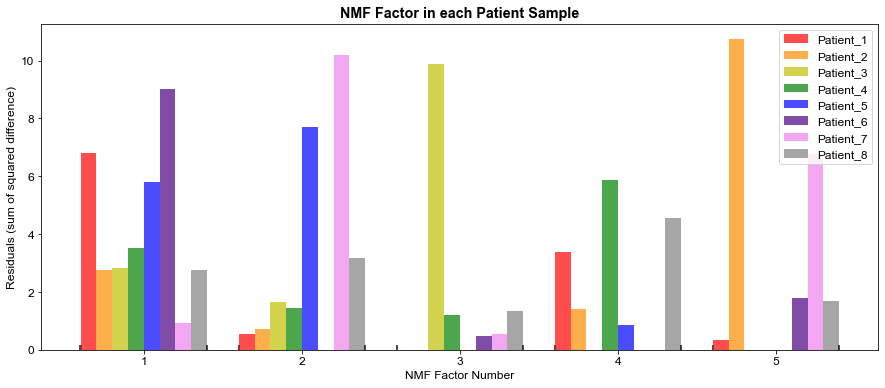

In [154]:
pt1_values = res_nmf_dissbulks.loc[0].values
pt2_values = res_nmf_dissbulks.loc[1].values
pt3_values = res_nmf_dissbulks.loc[2].values
pt4_values = res_nmf_dissbulks.loc[3].values
pt5_values = res_nmf_dissbulks.loc[4].values
pt6_values = res_nmf_dissbulks.loc[5].values
pt7_values = res_nmf_dissbulks.loc[6].values
pt8_values = res_nmf_dissbulks.loc[7].values

# Define custom colors
custom_colors = ['r', 'darkorange', 'y', 'g', 'b', 'indigo', 'violet', 'grey']

# Create x-coordinates for the bars
x_coordinates = np.arange(len(pt1_values)) + 1

# Width of each bar
bar_width = 0.1

# Set the font to Arial for all text
plt.rcParams['font.family'] = 'Arial'

plt.figure(figsize=(15, 6))

# Plot "Classic Bulks" residuals
plt.bar(x_coordinates - (bar_width * 4), 0.15, width=0.015, alpha=0.7, color='black')
plt.bar(x_coordinates - (bar_width * 3.5), pt1_values, width=bar_width, alpha=0.7, label='Patient_1', color=custom_colors[0])

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates - (bar_width * 2.5), pt2_values, width=bar_width, alpha=0.7, label='Patient_2', color=custom_colors[1])

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates - (bar_width * 1.5), pt3_values, width=bar_width, alpha=0.7, label='Patient_3', color=custom_colors[2])

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates - (bar_width * 0.5), pt4_values, width=bar_width, alpha=0.7, label='Patient_4', color=custom_colors[3])

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates + (bar_width * 0.5), pt5_values, width=bar_width, alpha=0.7, label='Patient_5', color=custom_colors[4])

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates + (bar_width * 1.5), pt6_values, width=bar_width, alpha=0.7, label='Patient_6', color=custom_colors[5])

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates + (bar_width * 2.5), pt7_values, width=bar_width, alpha=0.7, label='Patient_7', color=custom_colors[6])

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates + (bar_width * 3.5), pt8_values, width=bar_width, alpha=0.7, label='Patient_8', color=custom_colors[7])
plt.bar(x_coordinates + (bar_width * 4), 0.15, width=0.015, alpha=0.7, color='black')
plt.xlabel('NMF Factor Number')
plt.ylabel('Residuals (sum of squared difference)')

# Set the title to bold
plt.title('NMF Factor in each Patient Sample', fontweight='bold')

plt.xticks(x_coordinates)  # Adjust x-axis labels

# Move the legend to the upper right corner
plt.legend()

plt.show()

And Classic Bulks

In [155]:
#NMF Residual(by sample) of bulks
num_nmf = 5
nmf = NMF(n_components = num_nmf, max_iter=10000, init="nndsvd")
res_nmf_df = nmf.fit_transform(residuals_bulks_shift)
components_bulks = nmf.components_
res_nmf_df = pd.DataFrame(res_nmf_df)
res_nmf_bulks = res_nmf_df
components_bulks = pd.DataFrame(components_bulks)
components_bulks.columns = gene_ids
components_bulks

/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  warnings.warn(


,A1BG,A1BG-AS1,A2M,A2M-AS1,A4GALT,AAAS,AACS,AAGAB,AAK1,AAMDC,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,0.080561,0.097816,0.146883,0.097001,0.100153,0.131075,0.118603,0.115368,0.134948,0.061474,...,0.101454,0.122121,0.103366,0.126248,0.099314,0.099229,0.137667,0.140165,0.096312,0.159828
1,0.061640,0.080367,0.125632,0.085279,0.096418,0.095320,0.118582,0.091174,0.088132,0.051035,...,0.086564,0.086053,0.079216,0.067661,0.088371,0.094050,0.087180,0.118933,0.149646,0.158703
2,0.043593,0.055312,0.083292,0.055167,0.060394,0.071968,0.065902,0.059765,0.072900,0.035535,...,0.054942,0.062854,0.056494,0.066447,0.061643,0.063821,0.099821,0.062509,0.041481,0.103344
3,0.048207,0.061703,0.096278,0.063835,0.052230,0.083392,0.058020,0.080526,0.070861,0.041548,...,0.068504,0.065091,0.070284,0.061217,0.067102,0.065482,0.096603,0.087716,0.098032,0.120472
4,0.045473,0.057189,0.088071,0.056889,0.052556,0.079688,0.078331,0.063495,0.085134,0.048724,...,0.056954,0.076798,0.059248,0.059883,0.058515,0.059537,0.102259,0.075976,0.085521,0.097631


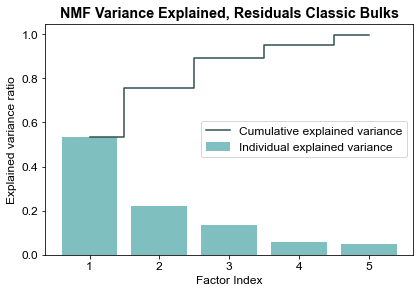

In [156]:
# W and H are your NMF results
V = residuals_bulks_shift.values
W = res_nmf_bulks.values
H = components_bulks.values # Solve for H using least squares

# Calculate the explained variance for each component
explained_variance = []
for i in range(W.shape[1]):
    WH = np.dot(W[:, :i+1], H[:i+1, :])
    explained_variance.append(1 - np.linalg.norm(V - WH, 'fro')**2 / np.linalg.norm(V, 'fro')**2)

cum_sum = explained_variance

indiv_variance =  [cum_sum[0], 
                cum_sum[1] - cum_sum[0],
                cum_sum[2]- cum_sum[1],
                cum_sum[3] - cum_sum[2],
                cum_sum[4] - cum_sum[3] ]


## plot variance explained
plt.bar(range(1,len(indiv_variance)+1), indiv_variance, alpha=0.5, align='center', label='Individual explained variance',color='teal')
plt.step(range(1,len(cum_sum)+1), cum_sum, where='mid',label='Cumulative explained variance', color='darkslategrey')
plt.ylabel('Explained variance ratio', fontname="Arial")
plt.xlabel('Factor Index', fontname="Arial")
plt.legend(loc='best')
plt.tight_layout()
plt.title(f"NMF Variance Explained, Residuals Classic Bulks", fontweight='bold', fontname="Arial")
plt.show()

In [157]:
num_components = 5
W = res_nmf_bulks.values
H = components_bulks.values

comp_genes = dict()

# Iterate through each component
for component_idx in range(0,5):
    # Sort genes by their influence on the current component
    sorted_genes = residuals_bulks.columns[np.argsort(H[component_idx])]

    # Visualize the top N genes that contribute the most to the current component
    N = 10
    top_genes = sorted_genes[-N:]

    print(f"Genes contributing the most to NMF Component {component_idx + 1}:")
    print(top_genes)
 
    comp_genes[component_idx] =top_genes

Genes contributing the most to NMF Component 1:
Index(['L1CAM', 'PPL', 'CEP192', 'NCAPD2', 'ALMS1', 'ABCC5', 'CAD', 'CGN',
       'EPPK1', 'KIF1A'],
      dtype='object')
Genes contributing the most to NMF Component 2:
Index(['PLXNA4', 'TNC', 'DCUN1D3', 'FHL1', 'ITIH5', 'SORBS1', 'DOCK11',
       'ADAMTS2', 'LPL', 'SYNE3'],
      dtype='object')
Genes contributing the most to NMF Component 3:
Index(['PLEKHH1', 'AL590560.3', 'AC083843.3', 'ATP2B2', 'MPPED2', 'ACPP',
       'AMY2B', 'WDR97', 'PIGR', 'TMEM132C'],
      dtype='object')
Genes contributing the most to NMF Component 4:
Index(['CD4', 'GBP5', 'HLA-DMB', 'SIGLEC1', 'CIITA', 'ACP5', 'FPR3', 'LILRB4',
       'PIGR', 'HLA-DOA'],
      dtype='object')
Genes contributing the most to NMF Component 5:
Index(['POLD1', 'AC136475.3', 'NRXN3', 'TBC1D2', 'TSKU', 'SLC44A4', 'CAPN5',
       'KRT16', 'AC022509.1', 'CYP4F11'],
      dtype='object')


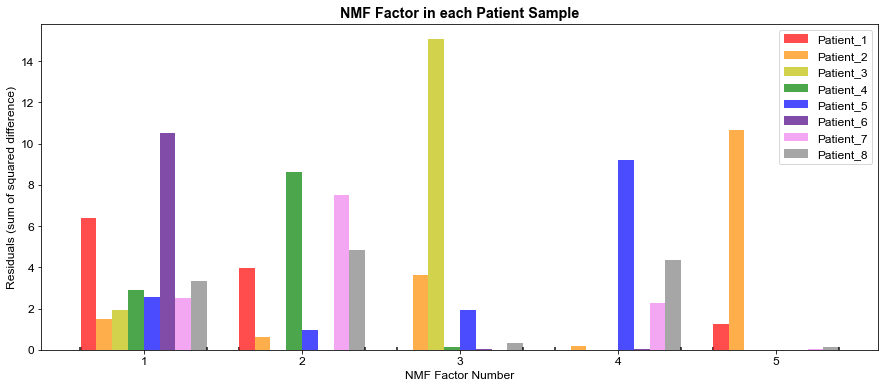

In [158]:
pt1_values = res_nmf_bulks.loc[0].values
pt2_values = res_nmf_bulks.loc[1].values
pt3_values = res_nmf_bulks.loc[2].values
pt4_values = res_nmf_bulks.loc[3].values
pt5_values = res_nmf_bulks.loc[4].values
pt6_values = res_nmf_bulks.loc[5].values
pt7_values = res_nmf_bulks.loc[6].values
pt8_values = res_nmf_bulks.loc[7].values

# Define custom colors
custom_colors = ['r', 'darkorange', 'y', 'g', 'b', 'indigo', 'violet', 'grey']

# Create x-coordinates for the bars
x_coordinates = np.arange(len(pt1_values)) + 1

# Width of each bar
bar_width = 0.1

# Set the font to Arial for all text
plt.rcParams['font.family'] = 'Arial'

plt.figure(figsize=(15, 6))

# Plot "Classic Bulks" residuals
plt.bar(x_coordinates - (bar_width * 4), 0.15, width=0.015, alpha=0.7, color='black')
plt.bar(x_coordinates - (bar_width * 3.5), pt1_values, width=bar_width, alpha=0.7, label='Patient_1', color=custom_colors[0])

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates - (bar_width * 2.5), pt2_values, width=bar_width, alpha=0.7, label='Patient_2', color=custom_colors[1])

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates - (bar_width * 1.5), pt3_values, width=bar_width, alpha=0.7, label='Patient_3', color=custom_colors[2])

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates - (bar_width * 0.5), pt4_values, width=bar_width, alpha=0.7, label='Patient_4', color=custom_colors[3])

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates + (bar_width * 0.5), pt5_values, width=bar_width, alpha=0.7, label='Patient_5', color=custom_colors[4])

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates + (bar_width * 1.5), pt6_values, width=bar_width, alpha=0.7, label='Patient_6', color=custom_colors[5])

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates + (bar_width * 2.5), pt7_values, width=bar_width, alpha=0.7, label='Patient_7', color=custom_colors[6])

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates + (bar_width * 3.5), pt8_values, width=bar_width, alpha=0.7, label='Patient_8', color=custom_colors[7])
plt.bar(x_coordinates + (bar_width * 4), 0.15, width=0.015, alpha=0.7, color='black')
plt.xlabel('NMF Factor Number')
plt.ylabel('Residuals (sum of squared difference)')

# Set the title to bold
plt.title('NMF Factor in each Patient Sample', fontweight='bold')

plt.xticks(x_coordinates)  # Adjust x-axis labels

# Move the legend to the upper right corner
plt.legend()

plt.show()

In [166]:
# Extract the third row
num = 6
third_row = residuals_bulks.values[num, :]  # Note: Python uses 0-based indexing, so the third row is at index 2

# Get the indices of the top 10 genes with the highest expression
top_10_genes_indices = np.argsort(third_row)[::-1][:10]

# Extract the gene names corresponding to the top 10 indices
gene_names_top_10 = residuals_bulks.columns[top_10_genes_indices]  # Replace 'your_gene_names' with the actual names of your genes

print(f"Top 10 most expressed genes in the {num}sample:")
for gene_name in gene_names_top_10:
    print(gene_name)

Top 10 most expressed genes in the 6sample:
CR1
GPAM
SIGLEC1
MPEG1
SYNE3
RMRP
RETSAT
MMRN2
LRRK2
ACACB
